In [1]:
import pandas as pd
import numpy as np
import random
import gc
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder,MinMaxScaler, StandardScaler
from sklearn.metrics import recall_score, auc, accuracy_score, f1_score, precision_score, classification_report, roc_auc_score,mean_squared_error
from pandas.api.types import is_categorical_dtype
from pandas.api.types import is_datetime64_any_dtype as is_datetime
import missingno as msno
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

In [2]:
data = pd.read_csv('./FE_data/data.csv')

In [3]:
data.isna().sum()

role_id            0
r1                 0
r2                 0
r3                 0
r4                 0
max_role_level     0
p1                 0
p2                 0
p3                 0
p4                 0
p5                 0
p6                 0
is_create_role     0
is_create_no       0
server_sum         0
platform           0
user_type          0
user_flag          0
mobile             0
game_pay_num       0
chmoney_pay_num    0
30d_pay_money      0
dtype: int64

In [4]:
# 前30天有付费的
data_pay_30 = data[data['30d_pay_money'] != 0]
print(data_pay_30['30d_pay_money'].describe())
print('前30天付费总金额:', data_pay_30['30d_pay_money'].sum())

count    126178.000000
mean        759.704267
std        3612.467840
min           2.000000
25%          24.000000
50%          90.000000
75%         304.000000
max      156788.000000
Name: 30d_pay_money, dtype: float64
前30天付费总金额: 95857965.0


In [5]:
# 前7天有付费的
data_pay_7 = data[data['p2'] != 0]
print(data_pay_7['p2'].describe())
print('-'*20)
print('总角色数：', data.shape[0])
print('前7天付费角色数：', data_pay_7.shape[0])
print('前7天付费率(付费人数/总人数):{:.2%}'.format(data_pay_7.shape[0]/data.shape[0]))
print('前7天合计付费:', data_pay_7['p2'].sum())
print('前7天有付费的角色前30前合计付费', data_pay_7['30d_pay_money'].sum())

count    115028.000000
mean        363.610312
std        1396.247491
min           2.000000
25%          12.000000
50%          60.000000
75%         216.000000
max       54324.000000
Name: p2, dtype: float64
--------------------
总角色数： 5164372
前7天付费角色数： 115028
前7天付费率(付费人数/总人数):2.23%
前7天合计付费: 41825367.0
前7天有付费的角色前30前合计付费 93557907.0


In [6]:
# 前7天没有付费，但之后23天有付费的
data_nopay_7_pay_30 = data_pay_30[data_pay_30['p2'] == 0]
print(data_nopay_7_pay_30['30d_pay_money'].describe())
print('前7天没有付费，后23天有付费的合计付费:', data_nopay_7_pay_30['30d_pay_money'].sum())

count    11150.000000
mean       206.283229
std        876.932623
min          6.000000
25%         24.000000
50%         60.000000
75%        188.000000
max      31090.000000
Name: 30d_pay_money, dtype: float64
前7天没有付费，后23天有付费的合计付费: 2300058.0


In [7]:
# 前7天有付费，且之后23天有付费的
data_pay_7_pay_30 = data_pay_7[data_pay_7['p2'] < data_pay_7['30d_pay_money']]
print(data_pay_7_pay_30['30d_pay_money'].describe())
print(data_pay_7_pay_30['p1'].describe())
print('前7天合计付费', data_pay_7_pay_30['p2'].sum())
print('前30天合计付费', data_pay_7_pay_30['30d_pay_money'].sum())
print('前7天付费的角色，后面23天继续付费金额:', data_pay_7_pay_30['30d_pay_money'].sum()-data_pay_7_pay_30['p2'].sum())
print('前30天付费，后面23天继续付费的人数:', data_pay_7_pay_30.shape[0])

count     41308.000000
mean       1995.168926
std        6067.875053
min          18.000000
25%         180.000000
50%         378.000000
75%        1130.000000
max      156788.000000
Name: 30d_pay_money, dtype: float64
count    41308.000000
mean         7.648325
std          9.627304
min          1.000000
25%          2.000000
50%          4.000000
75%          9.000000
max        140.000000
Name: p1, dtype: float64
前7天合计付费 30683898.0
前30天合计付费 82416438.0
前7天付费的角色，后面23天继续付费金额: 51732540.0
前30天付费，后面23天继续付费的人数: 41308


In [8]:
# 前7天有付费，但之后23天没有再付费的
data_pay_7_nopay_30 = data_pay_7[data_pay_7['p2'] == data_pay_7['30d_pay_money']]
print(data_pay_7_nopay_30['30d_pay_money'].describe())
print('-'*20)
print('前7天付费，但后23天没有继续付费的角色数', data_pay_7_nopay_30.shape[0])
print('前7天付费，但后23天没有继续付费的角色总付费', data_pay_7_nopay_30['30d_pay_money'].sum())

count    73720.000000
mean       151.132244
std        563.044790
min          2.000000
25%         12.000000
50%         30.000000
75%        110.000000
max      23420.000000
Name: 30d_pay_money, dtype: float64
--------------------
前7天付费，但后23天没有继续付费的角色数 73720
前7天付费，但后23天没有继续付费的角色总付费 11141469.0


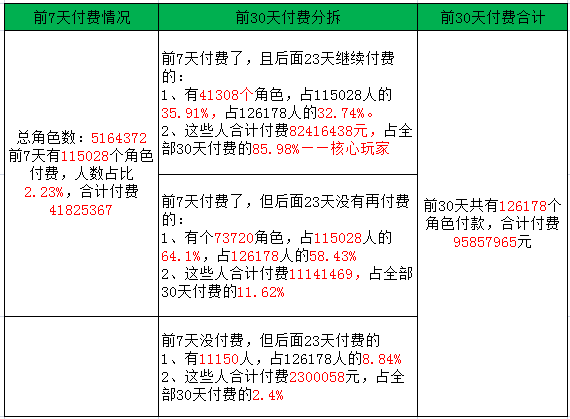

In [9]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
data['p2'].describe()

count   5164372.00
mean          8.10
std         215.18
min           0.00
25%           0.00
50%           0.00
75%           0.00
max       54324.00
Name: p2, dtype: float64

In [10]:
data

,role_id,r1,r2,r3,r4,max_role_level,p1,p2,p3,p4,...,is_create_role,is_create_no,server_sum,platform,user_type,user_flag,mobile,game_pay_num,chmoney_pay_num,30d_pay_money
0,11263507,1,1,1,0.00,0,0.00,0.00,0.00,0.00,...,1.00,1.00,1.00,2.00,1.00,1.00,0.00,0.00,0.00,0.00
1,11265111,3,1,1,0.02,1,0.00,0.00,0.00,0.00,...,1.00,1.00,1.00,2.00,1.00,1.00,0.00,0.00,0.00,0.00
2,11265397,4,1,1,0.01,1,0.00,0.00,0.00,0.00,...,1.00,1.00,1.00,2.00,1.00,1.00,0.00,0.00,0.00,0.00
3,11269078,4,1,1,0.01,1,0.00,0.00,0.00,0.00,...,1.00,1.00,1.00,2.00,1.00,1.00,0.00,0.00,0.00,0.00
4,11271222,12,1,1,0.02,1,0.00,0.00,0.00,0.00,...,1.00,1.00,1.00,2.00,1.00,1.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5164367,152603019,1,1,1,0.00,2,0.00,0.00,0.00,0.00,...,1.00,1.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00
5164368,152603169,1,1,1,0.00,0,0.00,0.00,0.00,0.00,...,1.00,1.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00
5164369,152603896,1,1,1,0.00,2,0.00,0.00,0.00,0.00,...,1.00,1.00,1.00,1.00,2.00,1.00,1.00,0.00,0.00,0.00
5164370,152605228,1,1,1,0.00,2,0.00,0.00,0.00,0.00,...,1.00,1.00,1.00,1.00,2.00,1.00,1.00,0.00,0.00,0.00


In [11]:
numeric_features = ['']

# 策略：
## 1、前7天没有付费的占了97.77% ，这部分人后面再付费的金额只占全部付费的2.4%，因此将这部分人直接预测为30天内不会再付费。
## 2、前7天付费的，预测后面会不会继续付费，继续付的为1，不付的为0。标记为0的这部分人，预测前30天的付费金额=前7天的付费金额
## 3、标记为1的这部分人，占全部付费的86%，做回归模型，预测这部分前30天的付费金额。

In [12]:
pd.set_option('display.max_columns', None)
print(data.shape)
data.head()

(5164372, 22)


,role_id,r1,r2,r3,r4,max_role_level,p1,p2,p3,p4,p5,p6,is_create_role,is_create_no,server_sum,platform,user_type,user_flag,mobile,game_pay_num,chmoney_pay_num,30d_pay_money
0,11263507,1,1,1,0.00,0,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,2.00,1.00,1.00,0.00,0.00,0.00,0.00
1,11265111,3,1,1,0.02,1,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,2.00,1.00,1.00,0.00,0.00,0.00,0.00
2,11265397,4,1,1,0.01,1,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,2.00,1.00,1.00,0.00,0.00,0.00,0.00
3,11269078,4,1,1,0.01,1,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,2.00,1.00,1.00,0.00,0.00,0.00,0.00
4,11271222,12,1,1,0.02,1,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,2.00,1.00,1.00,0.00,0.00,0.00,0.00


In [13]:
# 对前7天付费的角色进行分组标记，其中前7天付费金额p2=前30付费金额的（前7天付费，后面23天没有付费）记为0，其它为1
data['continue_pay'] = (data['p2'] == data['30d_pay_money'])
data['continue_pay'] = data['continue_pay'].apply(lambda x: 0 if x is True else 1)
# 首先将data分为train和test，train用于训练所有模型，test用于最后的检验
data_train, data_test = train_test_split(data, test_size=0.25)

# 使用data_train进行训练模型

In [14]:
train_data_pay_7 = data_train[data_train['p2'] != 0]
train_data_nopay_7 = data_train[data_train['p2'] == 0]

In [15]:
train_data_pay_7['continue_pay'].value_counts()

0    55142
1    30994
Name: continue_pay, dtype: int64

In [16]:
train_data_pay_7.head()

,role_id,r1,r2,r3,r4,max_role_level,p1,p2,p3,p4,p5,p6,is_create_role,is_create_no,server_sum,platform,user_type,user_flag,mobile,game_pay_num,chmoney_pay_num,30d_pay_money,continue_pay
5028784,145628096,38,1,21,4.33,71,9.00,508.00,0.00,0.00,9.00,508.00,1.00,1.00,1.00,1.00,2.00,1.00,1.00,1.00,0.00,576.00,1
464601,151879170,32,1,14,4.83,65,1.00,30.00,0.00,0.00,1.00,30.00,1.00,1.00,1.00,1.00,2.00,1.00,1.00,1.00,0.00,30.00,0
2373688,141031936,16,1,3,10.43,60,1.00,128.00,0.00,0.00,1.00,128.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,206.00,1
3904184,133697501,3,1,1,0.59,0,4.00,176.00,0.00,0.00,4.00,176.00,1.00,0.00,1.00,1.00,18.00,1.00,0.00,4.00,0.00,176.00,0
240294,12088087,39,1,3,3.84,1,1.00,30.00,0.00,0.00,1.00,30.00,1.00,1.00,1.00,2.00,1.00,1.00,0.00,1.00,0.00,30.00,0


In [17]:
train_data_pay_7_train, train_data_pay_7_test = train_test_split(train_data_pay_7, test_size=0.25)
target = train_data_pay_7_train['continue_pay']
features = train_data_pay_7_train.drop(['continue_pay','role_id','30d_pay_money','game_pay_num','chmoney_pay_num'], axis=1)
X_val, x_test, Y_val, y_test = train_test_split(features,target, test_size=0.3)

In [18]:
thresholds = [0.1,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9]
thresholds_2 = thresholds[:]

print(thresholds_2)
result_model_f1 = pd.DataFrame(index=thresholds_2)
print(result_model_f1)

[0.1, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
Empty DataFrame
Columns: []
Index: [0.1, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]


### GBDT模型

召回率recall_score: [0.83143179 0.62307138]
精确率precision_score: 0.673157812743418
准确率accruacy_score: 0.7568752902327022
f1_score: 0.6471469222704808


<Figure size 1440x960 with 0 Axes>

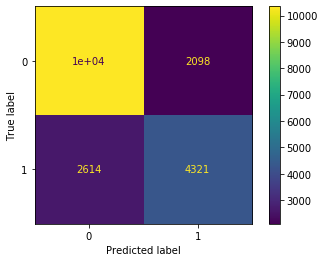

In [19]:
# 使用GBDT模型预测
from sklearn.ensemble import GradientBoostingClassifier
gbdt_b = GradientBoostingClassifier()
gbdt_b.fit(X_val, Y_val)
y_predict = gbdt_b.predict(x_test)
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
print('召回率recall_score:',recall_score(y_test.values, y_predict, average=None))
print('精确率precision_score:',precision_score(y_test.values, y_predict))
print('准确率accruacy_score:',accuracy_score(y_test.values, y_predict))
print('f1_score:',f1_score(y_test.values, y_predict))
plt.figure(figsize=(12, 8), dpi=120)
plot_confusion_matrix(gbdt_b,x_test, y_test)
plt.show()

In [20]:
y_predict = gbdt_b.predict_proba(x_test)
# 调试不用的thresholds，当为0.4、0.35时f1最高
for i in thresholds:
    y_test_predictions_high_recall = y_predict[:,1] >= i
    result_model_f1.loc[i, 'GBDT'] = f1_score(y_test.values, y_test_predictions_high_recall)
print(result_model_f1)

      GBDT
0.10  0.60
0.20  0.65
0.25  0.67
0.30  0.68
0.35  0.68
0.40  0.68
0.45  0.67
0.50  0.65
0.55  0.61
0.60  0.56
0.65  0.48
0.70  0.39
0.75  0.30
0.80  0.21
0.85  0.13
0.90  0.05


测试集召回率recall_score: [0.83028551 0.63449799]
测试集精确率precision_score: 0.6753767454721415
测试集准确率accruacy_score: 0.7602860592551314
测试集f1_score: 0.6542994910259844


<Figure size 1440x960 with 0 Axes>

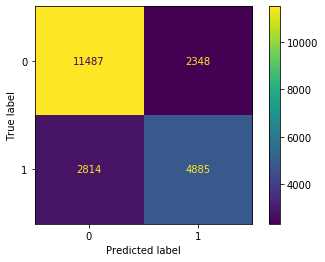

In [21]:
# GBDT 测试集测试
target_test = train_data_pay_7_test['continue_pay']
features_test = train_data_pay_7_test.drop(['continue_pay','role_id','30d_pay_money','game_pay_num','chmoney_pay_num'], axis=1)
y_predict_test = gbdt_b.predict(features_test)
print('测试集召回率recall_score:',recall_score(target_test.values, y_predict_test, average=None))
print('测试集精确率precision_score:',precision_score(target_test.values, y_predict_test))
print('测试集准确率accruacy_score:',accuracy_score(target_test.values, y_predict_test))
print('测试集f1_score:',f1_score(target_test.values, y_predict_test))
plt.figure(figsize=(12, 8), dpi=120)
plot_confusion_matrix(gbdt_b,features_test, target_test.values)
plt.show()

### lightGBM模型

In [22]:
# 不调参
params = {
"objective": "binary",
"boosting_type": "gbdt",
"learning_rate": 0.01,
"max_depth":3,
"num_leaves":35,
"min_child_samples":15,
"feature_fraction": 0.7,
"bagging_fraction":0.7,
"bagging_freq":10,
"lambda_l1":1,
"lambda_l2":2,
"metric": "auc",
}

train_data = lgb.Dataset(X_val, label=Y_val)
val_data = lgb.Dataset(x_test, label=y_test, reference=train_data)
lgb_b = lgb.train(params, train_data, num_boost_round=8000, early_stopping_rounds=100, valid_sets=[train_data, val_data])

[1]	training's auc: 0.770257	valid_1's auc: 0.765034
Training until validation scores don't improve for 100 rounds
[2]	training's auc: 0.777953	valid_1's auc: 0.774098
[3]	training's auc: 0.776424	valid_1's auc: 0.771017
[4]	training's auc: 0.78042	valid_1's auc: 0.774385
[5]	training's auc: 0.781265	valid_1's auc: 0.775919
[6]	training's auc: 0.781195	valid_1's auc: 0.775484
[7]	training's auc: 0.77877	valid_1's auc: 0.773285
[8]	training's auc: 0.78206	valid_1's auc: 0.777401
[9]	training's auc: 0.78394	valid_1's auc: 0.778953
[10]	training's auc: 0.785225	valid_1's auc: 0.779968
[11]	training's auc: 0.786424	valid_1's auc: 0.781536
[12]	training's auc: 0.787657	valid_1's auc: 0.782784
[13]	training's auc: 0.788947	valid_1's auc: 0.783754
[14]	training's auc: 0.789394	valid_1's auc: 0.784464
[15]	training's auc: 0.790329	valid_1's auc: 0.785387
[16]	training's auc: 0.790878	valid_1's auc: 0.785863
[17]	training's auc: 0.791218	valid_1's auc: 0.786289
[18]	training's auc: 0.79091	vali

[172]	training's auc: 0.806448	valid_1's auc: 0.800975
[173]	training's auc: 0.806492	valid_1's auc: 0.801017
[174]	training's auc: 0.806534	valid_1's auc: 0.80104
[175]	training's auc: 0.806654	valid_1's auc: 0.801163
[176]	training's auc: 0.806673	valid_1's auc: 0.801173
[177]	training's auc: 0.806733	valid_1's auc: 0.801186
[178]	training's auc: 0.80684	valid_1's auc: 0.80128
[179]	training's auc: 0.80687	valid_1's auc: 0.801292
[180]	training's auc: 0.806995	valid_1's auc: 0.801432
[181]	training's auc: 0.807276	valid_1's auc: 0.801721
[182]	training's auc: 0.807326	valid_1's auc: 0.80177
[183]	training's auc: 0.807379	valid_1's auc: 0.801801
[184]	training's auc: 0.807709	valid_1's auc: 0.802111
[185]	training's auc: 0.80777	valid_1's auc: 0.802201
[186]	training's auc: 0.807928	valid_1's auc: 0.802326
[187]	training's auc: 0.807987	valid_1's auc: 0.802375
[188]	training's auc: 0.808002	valid_1's auc: 0.802393
[189]	training's auc: 0.808057	valid_1's auc: 0.802433
[190]	training's

[323]	training's auc: 0.818267	valid_1's auc: 0.812036
[324]	training's auc: 0.818312	valid_1's auc: 0.812084
[325]	training's auc: 0.81839	valid_1's auc: 0.81216
[326]	training's auc: 0.818402	valid_1's auc: 0.812161
[327]	training's auc: 0.818452	valid_1's auc: 0.812207
[328]	training's auc: 0.818529	valid_1's auc: 0.812279
[329]	training's auc: 0.818579	valid_1's auc: 0.812326
[330]	training's auc: 0.818658	valid_1's auc: 0.812397
[331]	training's auc: 0.818675	valid_1's auc: 0.812406
[332]	training's auc: 0.818671	valid_1's auc: 0.812402
[333]	training's auc: 0.818699	valid_1's auc: 0.812417
[334]	training's auc: 0.818705	valid_1's auc: 0.812421
[335]	training's auc: 0.818716	valid_1's auc: 0.812427
[336]	training's auc: 0.818787	valid_1's auc: 0.812507
[337]	training's auc: 0.818791	valid_1's auc: 0.812512
[338]	training's auc: 0.818856	valid_1's auc: 0.812572
[339]	training's auc: 0.818869	valid_1's auc: 0.812592
[340]	training's auc: 0.818919	valid_1's auc: 0.812624
[341]	traini

[487]	training's auc: 0.824461	valid_1's auc: 0.81717
[488]	training's auc: 0.824465	valid_1's auc: 0.817172
[489]	training's auc: 0.82448	valid_1's auc: 0.81718
[490]	training's auc: 0.824483	valid_1's auc: 0.817182
[491]	training's auc: 0.824497	valid_1's auc: 0.817196
[492]	training's auc: 0.824513	valid_1's auc: 0.817202
[493]	training's auc: 0.824526	valid_1's auc: 0.817215
[494]	training's auc: 0.824537	valid_1's auc: 0.817223
[495]	training's auc: 0.824587	valid_1's auc: 0.817274
[496]	training's auc: 0.824607	valid_1's auc: 0.817284
[497]	training's auc: 0.824604	valid_1's auc: 0.817285
[498]	training's auc: 0.824615	valid_1's auc: 0.817293
[499]	training's auc: 0.824619	valid_1's auc: 0.817298
[500]	training's auc: 0.824676	valid_1's auc: 0.81735
[501]	training's auc: 0.824698	valid_1's auc: 0.817368
[502]	training's auc: 0.824716	valid_1's auc: 0.817384
[503]	training's auc: 0.824742	valid_1's auc: 0.817403
[504]	training's auc: 0.824766	valid_1's auc: 0.817422
[505]	training

[687]	training's auc: 0.829307	valid_1's auc: 0.821073
[688]	training's auc: 0.829327	valid_1's auc: 0.821082
[689]	training's auc: 0.829332	valid_1's auc: 0.821084
[690]	training's auc: 0.829352	valid_1's auc: 0.8211
[691]	training's auc: 0.829398	valid_1's auc: 0.82114
[692]	training's auc: 0.829416	valid_1's auc: 0.821155
[693]	training's auc: 0.829429	valid_1's auc: 0.821161
[694]	training's auc: 0.829475	valid_1's auc: 0.821199
[695]	training's auc: 0.829493	valid_1's auc: 0.821214
[696]	training's auc: 0.82951	valid_1's auc: 0.821228
[697]	training's auc: 0.829527	valid_1's auc: 0.821242
[698]	training's auc: 0.829535	valid_1's auc: 0.82124
[699]	training's auc: 0.829545	valid_1's auc: 0.821242
[700]	training's auc: 0.829585	valid_1's auc: 0.821277
[701]	training's auc: 0.8296	valid_1's auc: 0.821281
[702]	training's auc: 0.829627	valid_1's auc: 0.821305
[703]	training's auc: 0.829653	valid_1's auc: 0.82133
[704]	training's auc: 0.829666	valid_1's auc: 0.821335
[705]	training's a

[882]	training's auc: 0.833312	valid_1's auc: 0.824408
[883]	training's auc: 0.833318	valid_1's auc: 0.824407
[884]	training's auc: 0.833345	valid_1's auc: 0.824434
[885]	training's auc: 0.833349	valid_1's auc: 0.824434
[886]	training's auc: 0.833377	valid_1's auc: 0.82446
[887]	training's auc: 0.833383	valid_1's auc: 0.824461
[888]	training's auc: 0.833387	valid_1's auc: 0.824458
[889]	training's auc: 0.8334	valid_1's auc: 0.824467
[890]	training's auc: 0.833428	valid_1's auc: 0.824492
[891]	training's auc: 0.833437	valid_1's auc: 0.824498
[892]	training's auc: 0.833442	valid_1's auc: 0.824495
[893]	training's auc: 0.833471	valid_1's auc: 0.824521
[894]	training's auc: 0.833499	valid_1's auc: 0.824548
[895]	training's auc: 0.833518	valid_1's auc: 0.824566
[896]	training's auc: 0.833527	valid_1's auc: 0.824571
[897]	training's auc: 0.833554	valid_1's auc: 0.824596
[898]	training's auc: 0.833562	valid_1's auc: 0.824599
[899]	training's auc: 0.833589	valid_1's auc: 0.824629
[900]	trainin

[1079]	training's auc: 0.836191	valid_1's auc: 0.826797
[1080]	training's auc: 0.836202	valid_1's auc: 0.826807
[1081]	training's auc: 0.836207	valid_1's auc: 0.826807
[1082]	training's auc: 0.836227	valid_1's auc: 0.826822
[1083]	training's auc: 0.836249	valid_1's auc: 0.82684
[1084]	training's auc: 0.836262	valid_1's auc: 0.826846
[1085]	training's auc: 0.836266	valid_1's auc: 0.826847
[1086]	training's auc: 0.836277	valid_1's auc: 0.826857
[1087]	training's auc: 0.836285	valid_1's auc: 0.82686
[1088]	training's auc: 0.836308	valid_1's auc: 0.826877
[1089]	training's auc: 0.836316	valid_1's auc: 0.826879
[1090]	training's auc: 0.836335	valid_1's auc: 0.826895
[1091]	training's auc: 0.836367	valid_1's auc: 0.826925
[1092]	training's auc: 0.836399	valid_1's auc: 0.826955
[1093]	training's auc: 0.836432	valid_1's auc: 0.826982
[1094]	training's auc: 0.836464	valid_1's auc: 0.827011
[1095]	training's auc: 0.836468	valid_1's auc: 0.827014
[1096]	training's auc: 0.836475	valid_1's auc: 0.8

[1265]	training's auc: 0.838259	valid_1's auc: 0.828336
[1266]	training's auc: 0.838269	valid_1's auc: 0.828331
[1267]	training's auc: 0.838273	valid_1's auc: 0.828329
[1268]	training's auc: 0.838282	valid_1's auc: 0.828325
[1269]	training's auc: 0.838287	valid_1's auc: 0.828325
[1270]	training's auc: 0.838295	valid_1's auc: 0.82832
[1271]	training's auc: 0.838304	valid_1's auc: 0.828324
[1272]	training's auc: 0.838329	valid_1's auc: 0.828348
[1273]	training's auc: 0.838345	valid_1's auc: 0.82836
[1274]	training's auc: 0.838369	valid_1's auc: 0.828382
[1275]	training's auc: 0.838377	valid_1's auc: 0.828388
[1276]	training's auc: 0.838394	valid_1's auc: 0.828402
[1277]	training's auc: 0.838418	valid_1's auc: 0.828421
[1278]	training's auc: 0.838427	valid_1's auc: 0.828426
[1279]	training's auc: 0.838431	valid_1's auc: 0.828428
[1280]	training's auc: 0.838445	valid_1's auc: 0.828439
[1281]	training's auc: 0.838452	valid_1's auc: 0.828447
[1282]	training's auc: 0.838459	valid_1's auc: 0.8

[1418]	training's auc: 0.839931	valid_1's auc: 0.829595
[1419]	training's auc: 0.839937	valid_1's auc: 0.8296
[1420]	training's auc: 0.839942	valid_1's auc: 0.829602
[1421]	training's auc: 0.839963	valid_1's auc: 0.829616
[1422]	training's auc: 0.839965	valid_1's auc: 0.829616
[1423]	training's auc: 0.839971	valid_1's auc: 0.829618
[1424]	training's auc: 0.839974	valid_1's auc: 0.829622
[1425]	training's auc: 0.839995	valid_1's auc: 0.829636
[1426]	training's auc: 0.840015	valid_1's auc: 0.82965
[1427]	training's auc: 0.840021	valid_1's auc: 0.829653
[1428]	training's auc: 0.840028	valid_1's auc: 0.829657
[1429]	training's auc: 0.840037	valid_1's auc: 0.829656
[1430]	training's auc: 0.840057	valid_1's auc: 0.82967
[1431]	training's auc: 0.840083	valid_1's auc: 0.829685
[1432]	training's auc: 0.840092	valid_1's auc: 0.82969
[1433]	training's auc: 0.840118	valid_1's auc: 0.829704
[1434]	training's auc: 0.840144	valid_1's auc: 0.829718
[1435]	training's auc: 0.840151	valid_1's auc: 0.8297

[1602]	training's auc: 0.841468	valid_1's auc: 0.830607
[1603]	training's auc: 0.841483	valid_1's auc: 0.830618
[1604]	training's auc: 0.841503	valid_1's auc: 0.830634
[1605]	training's auc: 0.841504	valid_1's auc: 0.830628
[1606]	training's auc: 0.841512	valid_1's auc: 0.830632
[1607]	training's auc: 0.841513	valid_1's auc: 0.830628
[1608]	training's auc: 0.841512	valid_1's auc: 0.830626
[1609]	training's auc: 0.841515	valid_1's auc: 0.830621
[1610]	training's auc: 0.841534	valid_1's auc: 0.830638
[1611]	training's auc: 0.841536	valid_1's auc: 0.83064
[1612]	training's auc: 0.841542	valid_1's auc: 0.830641
[1613]	training's auc: 0.841546	valid_1's auc: 0.83064
[1614]	training's auc: 0.841551	valid_1's auc: 0.830642
[1615]	training's auc: 0.841554	valid_1's auc: 0.830641
[1616]	training's auc: 0.841557	valid_1's auc: 0.830637
[1617]	training's auc: 0.84156	valid_1's auc: 0.830641
[1618]	training's auc: 0.841564	valid_1's auc: 0.830642
[1619]	training's auc: 0.84157	valid_1's auc: 0.830

[1788]	training's auc: 0.842782	valid_1's auc: 0.831441
[1789]	training's auc: 0.842793	valid_1's auc: 0.831458
[1790]	training's auc: 0.842803	valid_1's auc: 0.831471
[1791]	training's auc: 0.842807	valid_1's auc: 0.83147
[1792]	training's auc: 0.842815	valid_1's auc: 0.831472
[1793]	training's auc: 0.84282	valid_1's auc: 0.831471
[1794]	training's auc: 0.842825	valid_1's auc: 0.831474
[1795]	training's auc: 0.842827	valid_1's auc: 0.831473
[1796]	training's auc: 0.842834	valid_1's auc: 0.831475
[1797]	training's auc: 0.842839	valid_1's auc: 0.831475
[1798]	training's auc: 0.842843	valid_1's auc: 0.831478
[1799]	training's auc: 0.842846	valid_1's auc: 0.831475
[1800]	training's auc: 0.842851	valid_1's auc: 0.831473
[1801]	training's auc: 0.842859	valid_1's auc: 0.831475
[1802]	training's auc: 0.842866	valid_1's auc: 0.831477
[1803]	training's auc: 0.842872	valid_1's auc: 0.831478
[1804]	training's auc: 0.842879	valid_1's auc: 0.831481
[1805]	training's auc: 0.842886	valid_1's auc: 0.8

[1934]	training's auc: 0.843676	valid_1's auc: 0.831976
[1935]	training's auc: 0.843683	valid_1's auc: 0.831982
[1936]	training's auc: 0.84369	valid_1's auc: 0.831989
[1937]	training's auc: 0.843693	valid_1's auc: 0.831988
[1938]	training's auc: 0.843697	valid_1's auc: 0.831993
[1939]	training's auc: 0.843701	valid_1's auc: 0.831994
[1940]	training's auc: 0.843707	valid_1's auc: 0.831999
[1941]	training's auc: 0.843711	valid_1's auc: 0.831997
[1942]	training's auc: 0.843715	valid_1's auc: 0.831994
[1943]	training's auc: 0.843723	valid_1's auc: 0.832001
[1944]	training's auc: 0.843727	valid_1's auc: 0.832003
[1945]	training's auc: 0.84373	valid_1's auc: 0.832003
[1946]	training's auc: 0.843734	valid_1's auc: 0.832004
[1947]	training's auc: 0.84374	valid_1's auc: 0.832002
[1948]	training's auc: 0.843742	valid_1's auc: 0.832001
[1949]	training's auc: 0.843745	valid_1's auc: 0.832001
[1950]	training's auc: 0.843749	valid_1's auc: 0.832001
[1951]	training's auc: 0.843755	valid_1's auc: 0.83

[2133]	training's auc: 0.844892	valid_1's auc: 0.832613
[2134]	training's auc: 0.844901	valid_1's auc: 0.832622
[2135]	training's auc: 0.84491	valid_1's auc: 0.83263
[2136]	training's auc: 0.844914	valid_1's auc: 0.832631
[2137]	training's auc: 0.844915	valid_1's auc: 0.832632
[2138]	training's auc: 0.844918	valid_1's auc: 0.83263
[2139]	training's auc: 0.844927	valid_1's auc: 0.832639
[2140]	training's auc: 0.844927	valid_1's auc: 0.83264
[2141]	training's auc: 0.84493	valid_1's auc: 0.832642
[2142]	training's auc: 0.844935	valid_1's auc: 0.832643
[2143]	training's auc: 0.844938	valid_1's auc: 0.832642
[2144]	training's auc: 0.844938	valid_1's auc: 0.83264
[2145]	training's auc: 0.844944	valid_1's auc: 0.832642
[2146]	training's auc: 0.844947	valid_1's auc: 0.832646
[2147]	training's auc: 0.844952	valid_1's auc: 0.83265
[2148]	training's auc: 0.844958	valid_1's auc: 0.83265
[2149]	training's auc: 0.844962	valid_1's auc: 0.832651
[2150]	training's auc: 0.844975	valid_1's auc: 0.832665


[2325]	training's auc: 0.8458	valid_1's auc: 0.833043
[2326]	training's auc: 0.845806	valid_1's auc: 0.833045
[2327]	training's auc: 0.845806	valid_1's auc: 0.833046
[2328]	training's auc: 0.84581	valid_1's auc: 0.833044
[2329]	training's auc: 0.845813	valid_1's auc: 0.833042
[2330]	training's auc: 0.845814	valid_1's auc: 0.833043
[2331]	training's auc: 0.845816	valid_1's auc: 0.833042
[2332]	training's auc: 0.845828	valid_1's auc: 0.833051
[2333]	training's auc: 0.84584	valid_1's auc: 0.833062
[2334]	training's auc: 0.845843	valid_1's auc: 0.833056
[2335]	training's auc: 0.845845	valid_1's auc: 0.833053
[2336]	training's auc: 0.845848	valid_1's auc: 0.83305
[2337]	training's auc: 0.845852	valid_1's auc: 0.833045
[2338]	training's auc: 0.845855	valid_1's auc: 0.833042
[2339]	training's auc: 0.845866	valid_1's auc: 0.83305
[2340]	training's auc: 0.845878	valid_1's auc: 0.833055
[2341]	training's auc: 0.845883	valid_1's auc: 0.833052
[2342]	training's auc: 0.845885	valid_1's auc: 0.83305

[2496]	training's auc: 0.846544	valid_1's auc: 0.833388
[2497]	training's auc: 0.846545	valid_1's auc: 0.833388
[2498]	training's auc: 0.846547	valid_1's auc: 0.833389
[2499]	training's auc: 0.846552	valid_1's auc: 0.833394
[2500]	training's auc: 0.846553	valid_1's auc: 0.833394
[2501]	training's auc: 0.846557	valid_1's auc: 0.833399
[2502]	training's auc: 0.846562	valid_1's auc: 0.833401
[2503]	training's auc: 0.846568	valid_1's auc: 0.833399
[2504]	training's auc: 0.846573	valid_1's auc: 0.833403
[2505]	training's auc: 0.846578	valid_1's auc: 0.833402
[2506]	training's auc: 0.846585	valid_1's auc: 0.833401
[2507]	training's auc: 0.846592	valid_1's auc: 0.833405
[2508]	training's auc: 0.846598	valid_1's auc: 0.833406
[2509]	training's auc: 0.846605	valid_1's auc: 0.833409
[2510]	training's auc: 0.84661	valid_1's auc: 0.833406
[2511]	training's auc: 0.846614	valid_1's auc: 0.833411
[2512]	training's auc: 0.846618	valid_1's auc: 0.833416
[2513]	training's auc: 0.846622	valid_1's auc: 0.

[2681]	training's auc: 0.847288	valid_1's auc: 0.833764
[2682]	training's auc: 0.84729	valid_1's auc: 0.833765
[2683]	training's auc: 0.847292	valid_1's auc: 0.833765
[2684]	training's auc: 0.847295	valid_1's auc: 0.833766
[2685]	training's auc: 0.847298	valid_1's auc: 0.833767
[2686]	training's auc: 0.8473	valid_1's auc: 0.833767
[2687]	training's auc: 0.8473	valid_1's auc: 0.833766
[2688]	training's auc: 0.847302	valid_1's auc: 0.833767
[2689]	training's auc: 0.847304	valid_1's auc: 0.833768
[2690]	training's auc: 0.847306	valid_1's auc: 0.833766
[2691]	training's auc: 0.84731	valid_1's auc: 0.83377
[2692]	training's auc: 0.847314	valid_1's auc: 0.833773
[2693]	training's auc: 0.847318	valid_1's auc: 0.833776
[2694]	training's auc: 0.847321	valid_1's auc: 0.833778
[2695]	training's auc: 0.847324	valid_1's auc: 0.833782
[2696]	training's auc: 0.847328	valid_1's auc: 0.833783
[2697]	training's auc: 0.847335	valid_1's auc: 0.833789
[2698]	training's auc: 0.847338	valid_1's auc: 0.833793

[2841]	training's auc: 0.847844	valid_1's auc: 0.834022
[2842]	training's auc: 0.84785	valid_1's auc: 0.834029
[2843]	training's auc: 0.84785	valid_1's auc: 0.834028
[2844]	training's auc: 0.847857	valid_1's auc: 0.834034
[2845]	training's auc: 0.847859	valid_1's auc: 0.834034
[2846]	training's auc: 0.847861	valid_1's auc: 0.834033
[2847]	training's auc: 0.847866	valid_1's auc: 0.83404
[2848]	training's auc: 0.847872	valid_1's auc: 0.834046
[2849]	training's auc: 0.847875	valid_1's auc: 0.834041
[2850]	training's auc: 0.847876	valid_1's auc: 0.834038
[2851]	training's auc: 0.847879	valid_1's auc: 0.834042
[2852]	training's auc: 0.847881	valid_1's auc: 0.834041
[2853]	training's auc: 0.847885	valid_1's auc: 0.834043
[2854]	training's auc: 0.847887	valid_1's auc: 0.834045
[2855]	training's auc: 0.84789	valid_1's auc: 0.834047
[2856]	training's auc: 0.847894	valid_1's auc: 0.834047
[2857]	training's auc: 0.847895	valid_1's auc: 0.834049
[2858]	training's auc: 0.847901	valid_1's auc: 0.834

[3008]	training's auc: 0.848447	valid_1's auc: 0.834257
[3009]	training's auc: 0.848449	valid_1's auc: 0.834256
[3010]	training's auc: 0.848451	valid_1's auc: 0.834254
[3011]	training's auc: 0.848459	valid_1's auc: 0.834255
[3012]	training's auc: 0.848462	valid_1's auc: 0.834257
[3013]	training's auc: 0.848468	valid_1's auc: 0.834257
[3014]	training's auc: 0.848473	valid_1's auc: 0.834256
[3015]	training's auc: 0.848479	valid_1's auc: 0.834255
[3016]	training's auc: 0.848487	valid_1's auc: 0.834255
[3017]	training's auc: 0.848493	valid_1's auc: 0.834257
[3018]	training's auc: 0.848497	valid_1's auc: 0.83426
[3019]	training's auc: 0.848502	valid_1's auc: 0.834259
[3020]	training's auc: 0.848506	valid_1's auc: 0.834262
[3021]	training's auc: 0.848511	valid_1's auc: 0.83426
[3022]	training's auc: 0.848518	valid_1's auc: 0.834264
[3023]	training's auc: 0.848523	valid_1's auc: 0.834263
[3024]	training's auc: 0.84853	valid_1's auc: 0.834266
[3025]	training's auc: 0.848534	valid_1's auc: 0.83

[3197]	training's auc: 0.849025	valid_1's auc: 0.834476
[3198]	training's auc: 0.849027	valid_1's auc: 0.834475
[3199]	training's auc: 0.84903	valid_1's auc: 0.834476
[3200]	training's auc: 0.849034	valid_1's auc: 0.834477
[3201]	training's auc: 0.849039	valid_1's auc: 0.834481
[3202]	training's auc: 0.849045	valid_1's auc: 0.834484
[3203]	training's auc: 0.849046	valid_1's auc: 0.834482
[3204]	training's auc: 0.849051	valid_1's auc: 0.834486
[3205]	training's auc: 0.849054	valid_1's auc: 0.834485
[3206]	training's auc: 0.849056	valid_1's auc: 0.834483
[3207]	training's auc: 0.849061	valid_1's auc: 0.834489
[3208]	training's auc: 0.849063	valid_1's auc: 0.834487
[3209]	training's auc: 0.849065	valid_1's auc: 0.834489
[3210]	training's auc: 0.84907	valid_1's auc: 0.834492
[3211]	training's auc: 0.849073	valid_1's auc: 0.834493
[3212]	training's auc: 0.849076	valid_1's auc: 0.834493
[3213]	training's auc: 0.849079	valid_1's auc: 0.834494
[3214]	training's auc: 0.849083	valid_1's auc: 0.8

[3371]	training's auc: 0.849632	valid_1's auc: 0.834793
[3372]	training's auc: 0.849637	valid_1's auc: 0.834791
[3373]	training's auc: 0.849643	valid_1's auc: 0.834789
[3374]	training's auc: 0.849653	valid_1's auc: 0.834795
[3375]	training's auc: 0.849656	valid_1's auc: 0.834796
[3376]	training's auc: 0.849662	valid_1's auc: 0.834797
[3377]	training's auc: 0.84967	valid_1's auc: 0.834804
[3378]	training's auc: 0.849675	valid_1's auc: 0.834802
[3379]	training's auc: 0.84968	valid_1's auc: 0.834802
[3380]	training's auc: 0.849685	valid_1's auc: 0.834802
[3381]	training's auc: 0.849684	valid_1's auc: 0.834802
[3382]	training's auc: 0.849687	valid_1's auc: 0.834805
[3383]	training's auc: 0.849689	valid_1's auc: 0.834803
[3384]	training's auc: 0.849689	valid_1's auc: 0.834803
[3385]	training's auc: 0.849689	valid_1's auc: 0.8348
[3386]	training's auc: 0.849692	valid_1's auc: 0.834805
[3387]	training's auc: 0.849696	valid_1's auc: 0.834804
[3388]	training's auc: 0.8497	valid_1's auc: 0.83481

[3569]	training's auc: 0.850242	valid_1's auc: 0.835057
[3570]	training's auc: 0.850243	valid_1's auc: 0.835058
[3571]	training's auc: 0.850245	valid_1's auc: 0.835058
[3572]	training's auc: 0.850247	valid_1's auc: 0.835057
[3573]	training's auc: 0.85025	valid_1's auc: 0.835057
[3574]	training's auc: 0.850253	valid_1's auc: 0.835053
[3575]	training's auc: 0.850253	valid_1's auc: 0.83505
[3576]	training's auc: 0.850255	valid_1's auc: 0.835051
[3577]	training's auc: 0.850258	valid_1's auc: 0.83505
[3578]	training's auc: 0.85026	valid_1's auc: 0.835049
[3579]	training's auc: 0.85026	valid_1's auc: 0.835049
[3580]	training's auc: 0.850262	valid_1's auc: 0.835048
[3581]	training's auc: 0.850263	valid_1's auc: 0.835047
[3582]	training's auc: 0.850265	valid_1's auc: 0.835045
[3583]	training's auc: 0.850266	valid_1's auc: 0.835044
[3584]	training's auc: 0.850267	valid_1's auc: 0.835042
[3585]	training's auc: 0.850268	valid_1's auc: 0.835041
[3586]	training's auc: 0.850269	valid_1's auc: 0.8350

[3765]	training's auc: 0.850698	valid_1's auc: 0.835176
[3766]	training's auc: 0.850698	valid_1's auc: 0.835174
[3767]	training's auc: 0.850699	valid_1's auc: 0.835174
[3768]	training's auc: 0.850701	valid_1's auc: 0.835176
[3769]	training's auc: 0.850702	valid_1's auc: 0.835177
[3770]	training's auc: 0.850705	valid_1's auc: 0.83518
[3771]	training's auc: 0.850708	valid_1's auc: 0.835181
[3772]	training's auc: 0.85071	valid_1's auc: 0.835181
[3773]	training's auc: 0.850712	valid_1's auc: 0.835185
[3774]	training's auc: 0.850716	valid_1's auc: 0.835188
[3775]	training's auc: 0.850718	valid_1's auc: 0.835191
[3776]	training's auc: 0.850722	valid_1's auc: 0.835192
[3777]	training's auc: 0.850723	valid_1's auc: 0.835191
[3778]	training's auc: 0.850726	valid_1's auc: 0.835193
[3779]	training's auc: 0.850729	valid_1's auc: 0.835194
[3780]	training's auc: 0.85073	valid_1's auc: 0.835192
[3781]	training's auc: 0.850733	valid_1's auc: 0.835193
[3782]	training's auc: 0.850734	valid_1's auc: 0.83

[3948]	training's auc: 0.851181	valid_1's auc: 0.835246
[3949]	training's auc: 0.851183	valid_1's auc: 0.835246
[3950]	training's auc: 0.851186	valid_1's auc: 0.835243
[3951]	training's auc: 0.851191	valid_1's auc: 0.835243
[3952]	training's auc: 0.851194	valid_1's auc: 0.835246
[3953]	training's auc: 0.851196	valid_1's auc: 0.835246
[3954]	training's auc: 0.851198	valid_1's auc: 0.835244
[3955]	training's auc: 0.851201	valid_1's auc: 0.835247
[3956]	training's auc: 0.851205	valid_1's auc: 0.835249
[3957]	training's auc: 0.851207	valid_1's auc: 0.83525
[3958]	training's auc: 0.851209	valid_1's auc: 0.835247
[3959]	training's auc: 0.851211	valid_1's auc: 0.835244
[3960]	training's auc: 0.851214	valid_1's auc: 0.835247
[3961]	training's auc: 0.851218	valid_1's auc: 0.835247
[3962]	training's auc: 0.85122	valid_1's auc: 0.835247
[3963]	training's auc: 0.851222	valid_1's auc: 0.835246
[3964]	training's auc: 0.851224	valid_1's auc: 0.835245
[3965]	training's auc: 0.851226	valid_1's auc: 0.8

[4126]	training's auc: 0.851667	valid_1's auc: 0.835313
[4127]	training's auc: 0.85167	valid_1's auc: 0.835315
[4128]	training's auc: 0.851671	valid_1's auc: 0.835312
[4129]	training's auc: 0.851673	valid_1's auc: 0.835313
[4130]	training's auc: 0.851676	valid_1's auc: 0.835313
[4131]	training's auc: 0.851681	valid_1's auc: 0.835311
[4132]	training's auc: 0.851685	valid_1's auc: 0.835308
[4133]	training's auc: 0.851689	valid_1's auc: 0.835308
[4134]	training's auc: 0.851692	valid_1's auc: 0.83531
[4135]	training's auc: 0.851696	valid_1's auc: 0.83531
[4136]	training's auc: 0.8517	valid_1's auc: 0.835309
[4137]	training's auc: 0.851704	valid_1's auc: 0.835308
[4138]	training's auc: 0.851707	valid_1's auc: 0.835309
[4139]	training's auc: 0.851709	valid_1's auc: 0.835306
[4140]	training's auc: 0.851711	valid_1's auc: 0.835308
[4141]	training's auc: 0.851715	valid_1's auc: 0.835308
[4142]	training's auc: 0.851714	valid_1's auc: 0.835308
[4143]	training's auc: 0.851714	valid_1's auc: 0.8353

[4320]	training's auc: 0.852123	valid_1's auc: 0.835461
[4321]	training's auc: 0.852129	valid_1's auc: 0.835469
[4322]	training's auc: 0.852135	valid_1's auc: 0.835473
[4323]	training's auc: 0.85214	valid_1's auc: 0.835478
[4324]	training's auc: 0.852146	valid_1's auc: 0.83548
[4325]	training's auc: 0.852152	valid_1's auc: 0.835478
[4326]	training's auc: 0.852157	valid_1's auc: 0.835481
[4327]	training's auc: 0.85216	valid_1's auc: 0.835479
[4328]	training's auc: 0.852165	valid_1's auc: 0.835483
[4329]	training's auc: 0.852171	valid_1's auc: 0.835487
[4330]	training's auc: 0.852174	valid_1's auc: 0.835486
[4331]	training's auc: 0.852175	valid_1's auc: 0.835485
[4332]	training's auc: 0.852178	valid_1's auc: 0.835484
[4333]	training's auc: 0.852181	valid_1's auc: 0.835483
[4334]	training's auc: 0.852181	valid_1's auc: 0.835484
[4335]	training's auc: 0.852183	valid_1's auc: 0.835483
[4336]	training's auc: 0.852188	valid_1's auc: 0.835481
[4337]	training's auc: 0.852192	valid_1's auc: 0.83

[4495]	training's auc: 0.852612	valid_1's auc: 0.835619
[4496]	training's auc: 0.852614	valid_1's auc: 0.83562
[4497]	training's auc: 0.852614	valid_1's auc: 0.83562
[4498]	training's auc: 0.852615	valid_1's auc: 0.835621
[4499]	training's auc: 0.852618	valid_1's auc: 0.835621
[4500]	training's auc: 0.852617	valid_1's auc: 0.83562
[4501]	training's auc: 0.852619	valid_1's auc: 0.835622
[4502]	training's auc: 0.852623	valid_1's auc: 0.835624
[4503]	training's auc: 0.852626	valid_1's auc: 0.835626
[4504]	training's auc: 0.852627	valid_1's auc: 0.835625
[4505]	training's auc: 0.852632	valid_1's auc: 0.835627
[4506]	training's auc: 0.852636	valid_1's auc: 0.835628
[4507]	training's auc: 0.852637	valid_1's auc: 0.835629
[4508]	training's auc: 0.852641	valid_1's auc: 0.835631
[4509]	training's auc: 0.852642	valid_1's auc: 0.835633
[4510]	training's auc: 0.852649	valid_1's auc: 0.835636
[4511]	training's auc: 0.852653	valid_1's auc: 0.835643
[4512]	training's auc: 0.852658	valid_1's auc: 0.83

[4646]	training's auc: 0.852943	valid_1's auc: 0.835733
[4647]	training's auc: 0.852944	valid_1's auc: 0.835735
[4648]	training's auc: 0.852945	valid_1's auc: 0.835739
[4649]	training's auc: 0.852947	valid_1's auc: 0.835737
[4650]	training's auc: 0.852947	valid_1's auc: 0.835739
[4651]	training's auc: 0.85295	valid_1's auc: 0.835739
[4652]	training's auc: 0.852953	valid_1's auc: 0.835739
[4653]	training's auc: 0.852956	valid_1's auc: 0.835739
[4654]	training's auc: 0.852959	valid_1's auc: 0.83574
[4655]	training's auc: 0.852961	valid_1's auc: 0.835743
[4656]	training's auc: 0.852963	valid_1's auc: 0.835742
[4657]	training's auc: 0.852966	valid_1's auc: 0.835741
[4658]	training's auc: 0.852966	valid_1's auc: 0.835743
[4659]	training's auc: 0.852969	valid_1's auc: 0.835746
[4660]	training's auc: 0.852971	valid_1's auc: 0.835745
[4661]	training's auc: 0.852974	valid_1's auc: 0.835747
[4662]	training's auc: 0.852977	valid_1's auc: 0.835747
[4663]	training's auc: 0.852978	valid_1's auc: 0.8

[4843]	training's auc: 0.853414	valid_1's auc: 0.835756
[4844]	training's auc: 0.853418	valid_1's auc: 0.835759
[4845]	training's auc: 0.85342	valid_1's auc: 0.835761
[4846]	training's auc: 0.853423	valid_1's auc: 0.83576
[4847]	training's auc: 0.853425	valid_1's auc: 0.835759
[4848]	training's auc: 0.853427	valid_1's auc: 0.835758
[4849]	training's auc: 0.853429	valid_1's auc: 0.835758
[4850]	training's auc: 0.85343	valid_1's auc: 0.835757
[4851]	training's auc: 0.853433	valid_1's auc: 0.835756
[4852]	training's auc: 0.853434	valid_1's auc: 0.835754
[4853]	training's auc: 0.853435	valid_1's auc: 0.83575
[4854]	training's auc: 0.853435	valid_1's auc: 0.83575
[4855]	training's auc: 0.853435	valid_1's auc: 0.835748
[4856]	training's auc: 0.853435	valid_1's auc: 0.835745
[4857]	training's auc: 0.853436	valid_1's auc: 0.835743
[4858]	training's auc: 0.853437	valid_1's auc: 0.835742
[4859]	training's auc: 0.853436	valid_1's auc: 0.835741
[4860]	training's auc: 0.853438	valid_1's auc: 0.8357

In [23]:
# 用train_data_pay_7_test数据集进行测试
target_test = train_data_pay_7_test['continue_pay']
features_test = train_data_pay_7_test.drop(['role_id', 'continue_pay','30d_pay_money','game_pay_num','chmoney_pay_num'], axis=1)
y_predict = lgb_b.predict(features_test)

In [24]:
sessoin = pd.DataFrame(y_predict, columns=['continue_pay'])
sessoin['continue_pay']=sessoin['continue_pay'].apply(lambda x:1 if x>=0.5 else 0)
y_predict_val = sessoin['continue_pay'].values
print(recall_score(target_test, y_predict_val, average=None))
print(precision_score(target_test, y_predict_val))
print(accuracy_score(target_test, y_predict_val))
print(f1_score(target_test, y_predict_val))

[0.82833394 0.65073386]
0.6784021665538253
0.764837001950404
0.6642800318217978


In [25]:
# 调试不用的thresholds，当为0.4、0.35时f1最高
for i in thresholds:
    y_test_predictions_high_recall = y_predict > i
    result_model_f1.loc[i, 'lgb_b'] = f1_score(target_test, y_test_predictions_high_recall)
print(result_model_f1)

      GBDT  lgb_b
0.10  0.60   0.62
0.20  0.65   0.66
0.25  0.67   0.68
0.30  0.68   0.69
0.35  0.68   0.69
0.40  0.68   0.69
0.45  0.67   0.68
0.50  0.65   0.66
0.55  0.61   0.64
0.60  0.56   0.59
0.65  0.48   0.53
0.70  0.39   0.44
0.75  0.30   0.35
0.80  0.21   0.26
0.85  0.13   0.17
0.90  0.05   0.10


<Figure size 864x432 with 0 Axes>

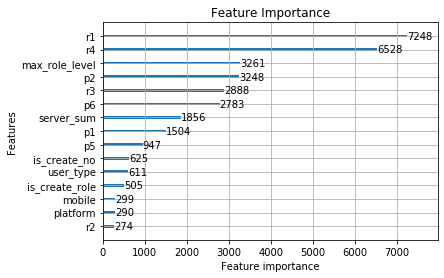

In [26]:
plt.figure(figsize=(12,6))
lgb.plot_importance(lgb_b, max_num_features=15)
plt.title('Feature Importance')
plt.show()

In [27]:
# # lgb的调参与交叉验证
# train_data = lgb.Dataset(X_val, label=Y_val)
# val_data = lgb.Dataset(x_test, label=y_test, reference=train_data)

# # 设置参数初始值，不含交叉验证参数
# print('设置参数')
# params = {
#     'boosting_type':'gbdt',
#     'objective':'binary',
#     'metric':'auc',
#     'nthread':4,
#     'learning_rate':0.01
# }

# # 交叉验证（调参）
# print('交叉验证')
# max_auc = float('0')
# best_params = {}

# # 准确率
# print('调参1：提高准确率')
# for num_leaves in range(5, 100, 5):
#     for max_depth in range(3, 8, 1):
#         params['num_leaves'] = num_leaves
#         params['max_depth'] = max_depth
        
#         cv_results = lgb.cv(
#                             params,
#                             train_data,
#                             seed=1,
#                             nfold=5,
#                             metrics=['auc'],
#                             early_stopping_rounds=10,
#                             verbose_eval=True     
#                             )
#         mean_auc = pd.Series(cv_results['auc-mean']).max()
#         boost_rounds = pd.Series(cv_results['auc-mean']).idxmax()
        
#         if mean_auc >= max_auc:
#             max_auc = mean_auc
#             best_params['num_leaves'] = num_leaves
#             best_params['max_depth'] = max_depth

# if 'num_leaves' and 'max_depth' in best_params.keys():
#     params['num_leaves'] = best_params['num_leaves']
#     params['max_depth'] = best_params['max_depth']

# # 过拟合
# print('调参2：降低过拟合')
# for max_bin in range(5, 256, 10):
#     for min_data_in_leaf in range(1, 102, 10):
#         params['max_bin'] = max_bin
#         params['min_data_in_leaf'] = min_data_in_leaf
        
#         cv_results = lgb.cv(
#                             params,
#                             train_data,
#                             seed=1,
#                             nfold=5,
#                             metrics=['auc'],
#                             early_stopping_rounds=10,
#                             verbose_eval=True
#                             )
#         mean_auc = pd.Series(cv_results['auc-mean']).max()
#         boost_rounds = pd.Series(cv_results['auc-mean']).idxmax()
        
#         if mean_auc >= max_auc:
#             max_auc = mean_auc
#             best_params['max_bin'] = max_bin
#             best_params['min_data_in_leaf'] = min_data_in_leaf

# if 'max_bin' and 'min_data_in_leaf' in best_params.keys():
#     params['max_bin'] = best_params['max_bin']
#     params['min_data_in_leaf'] = best_params['min_data_in_leaf']

# print('调参3：降低过拟合')
# for feature_fraction in [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
#     for bagging_fraction in [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
#         for bagging_freq in range(0,50,5):
#             params['feature_fraction'] = feature_fraction
#             params['bagging_fraction'] = bagging_fraction
#             params['bagging_freq'] = bagging_freq

#             cv_results = lgb.cv(
#                                 params,
#                                 train_data,
#                                 seed=1,
#                                 nfold=5,
#                                 metrics=['auc'],
#                                 early_stopping_rounds=10,
#                                 verbose_eval=True
#                                 )
#             mean_auc = pd.Series(cv_results['auc-mean']).max()
#             boost_rounds = pd.Series(cv_results['auc-mean']).idxmax()

#             if mean_auc >= max_auc:
#                 max_auc = mean_auc
#                 best_params['feature_fraction'] = feature_fraction
#                 best_params['bagging_fraction'] = bagging_fraction
#                 best_params['bagging_freq'] = bagging_freq

# if 'feature_fraction' and 'bagging_fraction' and 'bagging_freq' in best_params.keys():
#     params['feature_fraction'] = best_params['feature_fraction']
#     params['bagging_fraction'] = best_params['bagging_fraction']
#     params['bagging_freq'] = best_params['bagging_freq']

# print('调参4：降低过拟合')

# for lambda_l1 in [1e-5,1e-3,1e-1,0.0,0.1,0.3,0.5,0.7,0.9,1.0]:
#     for lambda_l2 in [1e-5,1e-3,1e-1,0.0,0.1,0.4,0.6,0.7,0.9,1.0]:
#         params['lambda_l1'] = lambda_l1
#         params['lambda_l2'] = lambda_l2
#         cv_results = lgb.cv(
#                             params,
#                             train_data,
#                             seed=1,
#                             nfold=5,
#                             metrics=['auc'],
#                             early_stopping_rounds=10,
#                             verbose_eval=True
#                             )
                
#         mean_auc = pd.Series(cv_results['auc-mean']).max()
#         boost_rounds = pd.Series(cv_results['auc-mean']).idxmax()
 
#         if mean_auc >= max_auc:
#             max_auc=mean_auc
#             best_params['lambda_l1'] = lambda_l1
#             best_params['lambda_l2'] = lambda_l2
# if 'lambda_l1' and 'lambda_l2' in best_params.keys():
#     params['lambda_l1'] = best_params['lambda_l1']
#     params['lambda_l2'] = best_params['lambda_l2']

# print("调参5：降低过拟合2")
# for min_split_gain in [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]:
#     params['min_split_gain'] = min_split_gain
    
#     cv_results = lgb.cv(
#                         params,
#                         train_data,
#                         seed=1,
#                         nfold=5,
#                         metrics=['auc'],
#                         early_stopping_rounds=10,
#                         verbose_eval=True
#                         )
            
#     mean_auc = pd.Series(cv_results['auc-mean']).max()
#     boost_rounds = pd.Series(cv_results['auc-mean']).idxmax()
 
#     if mean_auc >= max_auc:
#         max_auc=mean_auc
        
#         best_params['min_split_gain'] = min_split_gain
# if 'min_split_gain' in best_params.keys():
#     params['min_split_gain'] = best_params['min_split_gain']
# print(best_params)

In [28]:
# best_params{'num_leaves': 75, 'max_depth': 7, 'feature_fraction': 1.0, 'bagging_fraction': 0.5, 'bagging_freq': 5, 'lambda_l1': 0.0, 'lambda_l2': 0.001, 'min_split_gain': 0.0}

In [29]:
params = {

"nthread":4,
"objective": "binary",
"boosting_type": "gbdt",
"learning_rate": 0.01,
"max_depth":7,
"num_leaves":75,
"min_split_gain":0,
"feature_fraction": 1.0,
"bagging_fraction":0.5,
"bagging_freq":5,
"lambda_l1":0,
"lambda_l2":0.01,
"metric": "auc",
}

In [30]:
train_data = lgb.Dataset(X_val, label=Y_val)
val_data = lgb.Dataset(x_test, label=y_test, reference=train_data)
lgb_b_cv = lgb.train(params, train_data, num_boost_round=8000, early_stopping_rounds=100, valid_sets=[train_data, val_data])

[1]	training's auc: 0.816248	valid_1's auc: 0.804259
Training until validation scores don't improve for 100 rounds
[2]	training's auc: 0.816362	valid_1's auc: 0.804379
[3]	training's auc: 0.824391	valid_1's auc: 0.811833
[4]	training's auc: 0.825618	valid_1's auc: 0.813695
[5]	training's auc: 0.825415	valid_1's auc: 0.813861
[6]	training's auc: 0.827313	valid_1's auc: 0.815131
[7]	training's auc: 0.827691	valid_1's auc: 0.815168
[8]	training's auc: 0.827551	valid_1's auc: 0.814754
[9]	training's auc: 0.827498	valid_1's auc: 0.814733
[10]	training's auc: 0.827489	valid_1's auc: 0.814564
[11]	training's auc: 0.82822	valid_1's auc: 0.815127
[12]	training's auc: 0.828877	valid_1's auc: 0.815781
[13]	training's auc: 0.828979	valid_1's auc: 0.815893
[14]	training's auc: 0.829382	valid_1's auc: 0.816267
[15]	training's auc: 0.829222	valid_1's auc: 0.816168
[16]	training's auc: 0.830112	valid_1's auc: 0.817031
[17]	training's auc: 0.830597	valid_1's auc: 0.81753
[18]	training's auc: 0.830899	v

[185]	training's auc: 0.84355	valid_1's auc: 0.826608
[186]	training's auc: 0.843603	valid_1's auc: 0.826663
[187]	training's auc: 0.843631	valid_1's auc: 0.826684
[188]	training's auc: 0.843686	valid_1's auc: 0.826714
[189]	training's auc: 0.843707	valid_1's auc: 0.826729
[190]	training's auc: 0.843777	valid_1's auc: 0.826761
[191]	training's auc: 0.843837	valid_1's auc: 0.826789
[192]	training's auc: 0.843894	valid_1's auc: 0.826833
[193]	training's auc: 0.843936	valid_1's auc: 0.826865
[194]	training's auc: 0.84399	valid_1's auc: 0.826902
[195]	training's auc: 0.844026	valid_1's auc: 0.826925
[196]	training's auc: 0.84407	valid_1's auc: 0.826959
[197]	training's auc: 0.844111	valid_1's auc: 0.826989
[198]	training's auc: 0.84415	valid_1's auc: 0.827005
[199]	training's auc: 0.844185	valid_1's auc: 0.827034
[200]	training's auc: 0.84422	valid_1's auc: 0.827052
[201]	training's auc: 0.844256	valid_1's auc: 0.827087
[202]	training's auc: 0.844289	valid_1's auc: 0.827118
[203]	training'

[345]	training's auc: 0.851818	valid_1's auc: 0.831278
[346]	training's auc: 0.851898	valid_1's auc: 0.831324
[347]	training's auc: 0.851982	valid_1's auc: 0.831371
[348]	training's auc: 0.852058	valid_1's auc: 0.831417
[349]	training's auc: 0.852139	valid_1's auc: 0.831466
[350]	training's auc: 0.852215	valid_1's auc: 0.831514
[351]	training's auc: 0.85226	valid_1's auc: 0.831547
[352]	training's auc: 0.852304	valid_1's auc: 0.831576
[353]	training's auc: 0.852348	valid_1's auc: 0.831599
[354]	training's auc: 0.85239	valid_1's auc: 0.831627
[355]	training's auc: 0.852433	valid_1's auc: 0.831658
[356]	training's auc: 0.852485	valid_1's auc: 0.831682
[357]	training's auc: 0.85254	valid_1's auc: 0.831703
[358]	training's auc: 0.852589	valid_1's auc: 0.831727
[359]	training's auc: 0.852632	valid_1's auc: 0.831746
[360]	training's auc: 0.852684	valid_1's auc: 0.831769
[361]	training's auc: 0.85275	valid_1's auc: 0.831802
[362]	training's auc: 0.852814	valid_1's auc: 0.83183
[363]	training'

[515]	training's auc: 0.858318	valid_1's auc: 0.833565
[516]	training's auc: 0.858357	valid_1's auc: 0.833593
[517]	training's auc: 0.858396	valid_1's auc: 0.83362
[518]	training's auc: 0.858432	valid_1's auc: 0.833648
[519]	training's auc: 0.858467	valid_1's auc: 0.833677
[520]	training's auc: 0.858495	valid_1's auc: 0.833704
[521]	training's auc: 0.858534	valid_1's auc: 0.833712
[522]	training's auc: 0.858569	valid_1's auc: 0.833725
[523]	training's auc: 0.858594	valid_1's auc: 0.833731
[524]	training's auc: 0.858615	valid_1's auc: 0.833734
[525]	training's auc: 0.858628	valid_1's auc: 0.83374
[526]	training's auc: 0.858656	valid_1's auc: 0.833752
[527]	training's auc: 0.858686	valid_1's auc: 0.833765
[528]	training's auc: 0.858713	valid_1's auc: 0.833776
[529]	training's auc: 0.858745	valid_1's auc: 0.833789
[530]	training's auc: 0.858774	valid_1's auc: 0.833802
[531]	training's auc: 0.858801	valid_1's auc: 0.833818
[532]	training's auc: 0.858828	valid_1's auc: 0.833838
[533]	traini

[685]	training's auc: 0.86398	valid_1's auc: 0.8348
[686]	training's auc: 0.864019	valid_1's auc: 0.834805
[687]	training's auc: 0.864056	valid_1's auc: 0.834803
[688]	training's auc: 0.86409	valid_1's auc: 0.8348
[689]	training's auc: 0.864122	valid_1's auc: 0.8348
[690]	training's auc: 0.86416	valid_1's auc: 0.834796
[691]	training's auc: 0.86418	valid_1's auc: 0.8348
[692]	training's auc: 0.864198	valid_1's auc: 0.834802
[693]	training's auc: 0.864214	valid_1's auc: 0.834804
[694]	training's auc: 0.864231	valid_1's auc: 0.834807
[695]	training's auc: 0.864243	valid_1's auc: 0.834808
[696]	training's auc: 0.86426	valid_1's auc: 0.834811
[697]	training's auc: 0.864274	valid_1's auc: 0.834817
[698]	training's auc: 0.864288	valid_1's auc: 0.834822
[699]	training's auc: 0.864303	valid_1's auc: 0.834827
[700]	training's auc: 0.864315	valid_1's auc: 0.834834
[701]	training's auc: 0.864324	valid_1's auc: 0.834834
[702]	training's auc: 0.864332	valid_1's auc: 0.834834
[703]	training's auc: 0

[861]	training's auc: 0.868141	valid_1's auc: 0.835156
[862]	training's auc: 0.868175	valid_1's auc: 0.835162
[863]	training's auc: 0.8682	valid_1's auc: 0.835166
[864]	training's auc: 0.868227	valid_1's auc: 0.83517
[865]	training's auc: 0.868252	valid_1's auc: 0.835169
[866]	training's auc: 0.86828	valid_1's auc: 0.835171
[867]	training's auc: 0.868308	valid_1's auc: 0.835171
[868]	training's auc: 0.868331	valid_1's auc: 0.83517
[869]	training's auc: 0.868357	valid_1's auc: 0.835165
[870]	training's auc: 0.868378	valid_1's auc: 0.835161
[871]	training's auc: 0.868407	valid_1's auc: 0.83516
[872]	training's auc: 0.868428	valid_1's auc: 0.83516
[873]	training's auc: 0.868451	valid_1's auc: 0.835157
[874]	training's auc: 0.868476	valid_1's auc: 0.835154
[875]	training's auc: 0.868497	valid_1's auc: 0.835154
[876]	training's auc: 0.868526	valid_1's auc: 0.835151
[877]	training's auc: 0.868549	valid_1's auc: 0.835152
[878]	training's auc: 0.86857	valid_1's auc: 0.835149
[879]	training's a

[1013]	training's auc: 0.871665	valid_1's auc: 0.835412
[1014]	training's auc: 0.871693	valid_1's auc: 0.83541
[1015]	training's auc: 0.871712	valid_1's auc: 0.835417
[1016]	training's auc: 0.871721	valid_1's auc: 0.835421
[1017]	training's auc: 0.871728	valid_1's auc: 0.835421
[1018]	training's auc: 0.871735	valid_1's auc: 0.835421
[1019]	training's auc: 0.871741	valid_1's auc: 0.835419
[1020]	training's auc: 0.871748	valid_1's auc: 0.835423
[1021]	training's auc: 0.871759	valid_1's auc: 0.835422
[1022]	training's auc: 0.871769	valid_1's auc: 0.835422
[1023]	training's auc: 0.87178	valid_1's auc: 0.835423
[1024]	training's auc: 0.87179	valid_1's auc: 0.835423
[1025]	training's auc: 0.871799	valid_1's auc: 0.835421
[1026]	training's auc: 0.871828	valid_1's auc: 0.835426
[1027]	training's auc: 0.871858	valid_1's auc: 0.83543
[1028]	training's auc: 0.871886	valid_1's auc: 0.835436
[1029]	training's auc: 0.871911	valid_1's auc: 0.835441
[1030]	training's auc: 0.871939	valid_1's auc: 0.835

In [31]:
# 用train_data_pay_7_test数据集进行测试
target_test = train_data_pay_7_test['continue_pay']
features_test = train_data_pay_7_test.drop(['role_id', 'continue_pay','30d_pay_money','game_pay_num','chmoney_pay_num'], axis=1)
y_predict = lgb_b_cv.predict(features_test)
sessoin = pd.DataFrame(y_predict, columns=['continue_pay'])
sessoin['continue_pay']=sessoin['continue_pay'].apply(lambda x:1 if x>=0.5 else 0)
y_predict_val = sessoin['continue_pay'].values
print(recall_score(target_test, y_predict_val, average=None))
print(precision_score(target_test, y_predict_val))
print(accuracy_score(target_test, y_predict_val))
print(f1_score(target_test, y_predict_val))

[0.8262378  0.65605923]
0.677531857813548
0.7653942602396211
0.6666226738814834


In [32]:
# 调试不用的thresholds，当为0.4、0.35时f1最高
for i in thresholds:
    y_test_predictions_high_recall = y_predict > i
    result_model_f1.loc[i, 'lgb_b_cv'] = f1_score(target_test, y_test_predictions_high_recall)
print(result_model_f1)

      GBDT  lgb_b  lgb_b_cv
0.10  0.60   0.62      0.62
0.20  0.65   0.66      0.66
0.25  0.67   0.68      0.68
0.30  0.68   0.69      0.69
0.35  0.68   0.69      0.69
0.40  0.68   0.69      0.69
0.45  0.67   0.68      0.68
0.50  0.65   0.66      0.67
0.55  0.61   0.64      0.64
0.60  0.56   0.59      0.60
0.65  0.48   0.53      0.53
0.70  0.39   0.44      0.44
0.75  0.30   0.35      0.36
0.80  0.21   0.26      0.26
0.85  0.13   0.17      0.18
0.90  0.05   0.10      0.11


## 对前7天付费且后面23天也再次付费的玩家进行回归预测

In [33]:
train_data_pay_7_pay_30 = train_data_pay_7[train_data_pay_7['p2'] < train_data_pay_7['30d_pay_money']]
print(train_data_pay_7_pay_30.shape)
train_data_pay_7_pay_30.head()

(30994, 23)


,role_id,r1,r2,r3,r4,max_role_level,p1,p2,p3,p4,p5,p6,is_create_role,is_create_no,server_sum,platform,user_type,user_flag,mobile,game_pay_num,chmoney_pay_num,30d_pay_money,continue_pay
5028784,145628096,38,1,21,4.33,71,9.00,508.00,0.00,0.00,9.00,508.00,1.00,1.00,1.00,1.00,2.00,1.00,1.00,1.00,0.00,576.00,1
2373688,141031936,16,1,3,10.43,60,1.00,128.00,0.00,0.00,1.00,128.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,206.00,1
124312,142991739,32,1,15,5.13,66,1.00,30.00,0.00,0.00,1.00,30.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,194.00,1
4306563,148242133,36,1,12,4.57,73,29.00,3026.00,0.00,0.00,29.00,3026.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00,6.00,0.00,5256.00,1
2591328,150429135,24,1,6,6.96,65,2.00,80.00,0.00,0.00,2.00,80.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,336.00,1


In [34]:
train_data_pay_7_pay_30_train, train_data_pay_7_pay_30_test = train_test_split(train_data_pay_7_pay_30, test_size=0.25)
target = train_data_pay_7_pay_30_train['30d_pay_money']
features = train_data_pay_7_pay_30_train.drop(['continue_pay','role_id','30d_pay_money','game_pay_num','chmoney_pay_num'], axis=1)

In [35]:
features.head()

,r1,r2,r3,r4,max_role_level,p1,p2,p3,p4,p5,p6,is_create_role,is_create_no,server_sum,platform,user_type,user_flag,mobile
235942,59,1,14,2.80,69,4.00,226.00,0.00,0.00,4.00,226.00,1.00,1.00,2.00,1.00,1.00,1.00,1.00
4709257,121,1,16,1.37,1,1.00,30.00,0.00,0.00,1.00,30.00,1.00,1.00,1.00,2.00,1.00,1.00,0.00
1171824,34,1,22,4.75,0,9.00,892.00,0.00,0.00,9.00,892.00,1.00,0.00,1.00,1.00,18.00,1.00,0.00
2321927,41,1,6,4.09,67,6.00,196.00,0.00,0.00,6.00,195.00,1.00,1.00,9.00,1.00,1.00,1.00,0.00
2750211,46,1,8,3.64,73,18.00,6750.00,0.00,0.00,18.00,6750.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00


In [36]:
target.sort_values()

4429771       18.00
4177415       36.00
2204789       42.00
2938185       42.00
2774134       42.00
             ...   
1300441   103074.00
4735716   107618.00
4184642   115140.00
3326035   129240.00
2541491   156788.00
Name: 30d_pay_money, Length: 23245, dtype: float64

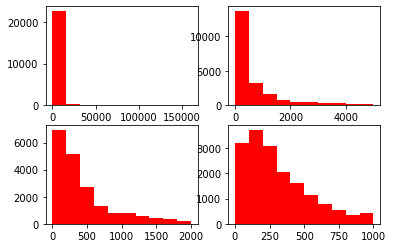

<Figure size 1600x800 with 0 Axes>

In [37]:
# 查看目标值的分布情况，大部分在4000以下
fig, axes = plt.subplots(2, 2)
ax1 = axes[0,0]
ax2 = axes[0,1]
ax3 = axes[1,0]
ax4 = axes[1,1]
fig = plt.figure(figsize=(20,10),dpi=80)
ax1.hist(target, color='red', range=(1, 160000))
ax2.hist(target, color='red', range=(1, 5000))
ax3.hist(target, color='red', range=(1, 2000))
ax4.hist(target, color='red', range=(1, 1000))
plt.show()

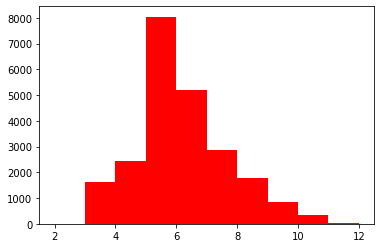

In [38]:
# 将target进行log1p转换，更符合正态分布
target_ln = np.log1p(target)
plt.hist(target_ln, color='red', range=(2, 12))
plt.show()

In [39]:
X_val, x_test, Y_val, y_test = train_test_split(features,target_ln, test_size=0.3)

In [40]:
# 使用GBDT模型预测
from sklearn.ensemble import GradientBoostingRegressor
gbdt_r=GradientBoostingRegressor(
  loss='ls'
, learning_rate=0.1
, n_estimators=100
, subsample=1
, min_samples_split=2
, min_samples_leaf=1
, max_depth=3
, init=None
, random_state=None
, max_features=None
, alpha=0.9
, verbose=0
, max_leaf_nodes=None
, warm_start=False
)
gbdt_r.fit(X_val, Y_val)
y_predict = gbdt_r.predict(x_test)
mse = mean_squared_error(np.expm1(y_predict), np.expm1(y_test))
mae = mean_absolute_error(np.expm1(y_predict), np.expm1(y_test))
rmse = mse ** 0.5
print(rmse)
print(mse)
print(mae)

3303.5696992486237
10913572.75779364
929.6413112679451


## 使用lightgbm进行回归

In [41]:
# 不调参
params = {
"objective": "regression",
"boosting_type": "gbdt",
"learning_rate": 0.01,
"num_leaves":1280,
"feature_fraction": 0.85,
"bagging_fraction":0.7,
"reg_lambda":2,
"random_seed":10,
"metric": "rmse",
}

train_data = lgb.Dataset(X_val, label=Y_val)
val_data = lgb.Dataset(x_test, label=y_test, reference=train_data)
lgb_r = lgb.train(params, train_data, num_boost_round=8000, early_stopping_rounds=100, valid_sets=[train_data, val_data])

[1]	training's rmse: 1.48319	valid_1's rmse: 1.4949
Training until validation scores don't improve for 100 rounds
[2]	training's rmse: 1.47168	valid_1's rmse: 1.48336
[3]	training's rmse: 1.46031	valid_1's rmse: 1.47203
[4]	training's rmse: 1.44906	valid_1's rmse: 1.46078
[5]	training's rmse: 1.43796	valid_1's rmse: 1.44965
[6]	training's rmse: 1.42699	valid_1's rmse: 1.43869
[7]	training's rmse: 1.41613	valid_1's rmse: 1.42783
[8]	training's rmse: 1.40543	valid_1's rmse: 1.41709
[9]	training's rmse: 1.39485	valid_1's rmse: 1.40653
[10]	training's rmse: 1.38439	valid_1's rmse: 1.39611
[11]	training's rmse: 1.37407	valid_1's rmse: 1.38582
[12]	training's rmse: 1.36387	valid_1's rmse: 1.37561
[13]	training's rmse: 1.3538	valid_1's rmse: 1.36556
[14]	training's rmse: 1.34384	valid_1's rmse: 1.35561
[15]	training's rmse: 1.33398	valid_1's rmse: 1.34579
[16]	training's rmse: 1.32426	valid_1's rmse: 1.33614
[17]	training's rmse: 1.31467	valid_1's rmse: 1.3266
[18]	training's rmse: 1.30519	va

[152]	training's rmse: 0.70339	valid_1's rmse: 0.766886
[153]	training's rmse: 0.701698	valid_1's rmse: 0.765829
[154]	training's rmse: 0.700053	valid_1's rmse: 0.764785
[155]	training's rmse: 0.698404	valid_1's rmse: 0.763787
[156]	training's rmse: 0.696809	valid_1's rmse: 0.762805
[157]	training's rmse: 0.695257	valid_1's rmse: 0.761811
[158]	training's rmse: 0.693694	valid_1's rmse: 0.760837
[159]	training's rmse: 0.692115	valid_1's rmse: 0.75989
[160]	training's rmse: 0.690563	valid_1's rmse: 0.758967
[161]	training's rmse: 0.689043	valid_1's rmse: 0.758064
[162]	training's rmse: 0.687582	valid_1's rmse: 0.757159
[163]	training's rmse: 0.686109	valid_1's rmse: 0.75627
[164]	training's rmse: 0.684675	valid_1's rmse: 0.755418
[165]	training's rmse: 0.683224	valid_1's rmse: 0.754564
[166]	training's rmse: 0.681789	valid_1's rmse: 0.753737
[167]	training's rmse: 0.680387	valid_1's rmse: 0.752918
[168]	training's rmse: 0.678935	valid_1's rmse: 0.752139
[169]	training's rmse: 0.677531	va

[298]	training's rmse: 0.571817	valid_1's rmse: 0.719281
[299]	training's rmse: 0.571275	valid_1's rmse: 0.719286
[300]	training's rmse: 0.570745	valid_1's rmse: 0.719291
[301]	training's rmse: 0.570249	valid_1's rmse: 0.719262
[302]	training's rmse: 0.569718	valid_1's rmse: 0.719252
[303]	training's rmse: 0.569172	valid_1's rmse: 0.719227
[304]	training's rmse: 0.568684	valid_1's rmse: 0.719249
[305]	training's rmse: 0.568171	valid_1's rmse: 0.719291
[306]	training's rmse: 0.567667	valid_1's rmse: 0.719278
[307]	training's rmse: 0.567149	valid_1's rmse: 0.719328
[308]	training's rmse: 0.566646	valid_1's rmse: 0.719328
[309]	training's rmse: 0.566129	valid_1's rmse: 0.719359
[310]	training's rmse: 0.565637	valid_1's rmse: 0.719404
[311]	training's rmse: 0.565175	valid_1's rmse: 0.719439
[312]	training's rmse: 0.564709	valid_1's rmse: 0.719446
[313]	training's rmse: 0.564181	valid_1's rmse: 0.719465
[314]	training's rmse: 0.56364	valid_1's rmse: 0.719497
[315]	training's rmse: 0.56314	v

In [42]:
y_predict = lgb_r.predict(x_test)
mse = mean_squared_error(np.expm1(y_predict), np.expm1(y_test))
mae = mean_absolute_error(np.expm1(y_predict), np.expm1(y_test))
rmse = mse ** 0.5
print(rmse)
print(mse)
print(mae)

3635.2217442037563
13214837.1295318
963.9868284638883


In [43]:
# # lgb的调参与交叉验证
# train_data = lgb.Dataset(X_val, label=Y_val)
# val_data = lgb.Dataset(x_test, label=y_test, reference=train_data)

# # 设置参数初始值，不含交叉验证参数
# print('设置参数')
# params = {
#     'boosting_type':'gbdt',
#     'objective':'regression',
#     'metric':'rmse',
#     'nthread':4,
#     'learning_rate':0.01
# }

# # 交叉验证（调参）
# print('交叉验证')
# max_rmse = float('0')
# best_params = {}

# # 准确率
# print('调参1：提高准确率')
# for num_leaves in range(5, 100, 5):
#     for max_depth in range(3, 8, 1):
#         params['num_leaves'] = num_leaves
#         params['max_depth'] = max_depth
        
#         cv_results = lgb.cv(
#                             params,
#                             train_data,
#                             seed=1,
#                             nfold=5,
#                             metrics=['rmse'],
#                             early_stopping_rounds=10,
#                             verbose_eval=True     
#                             )
#         mean_rmse = pd.Series(cv_results['rmse-mean']).max()
#         boost_rounds = pd.Series(cv_results['rmse-mean']).idxmax()
        
#         if mean_rmse >= max_rmse:
#             max_rmse = mean_rmse
#             best_params['num_leaves'] = num_leaves
#             best_params['max_depth'] = max_depth

# if 'num_leaves' and 'max_depth' in best_params.keys():
#     params['num_leaves'] = best_params['num_leaves']
#     params['max_depth'] = best_params['max_depth']

# # 过拟合
# print('调参2：降低过拟合')
# for max_bin in range(5, 256, 10):
#     for min_data_in_leaf in range(1, 102, 10):
#         params['max_bin'] = max_bin
#         params['min_data_in_leaf'] = min_data_in_leaf
        
#         cv_results = lgb.cv(
#                             params,
#                             train_data,
#                             seed=1,
#                             nfold=5,
#                             metrics=['rmse'],
#                             early_stopping_rounds=10,
#                             verbose_eval=True     
#                             )
#         mean_rmse = pd.Series(cv_results['rmse-mean']).max()
#         boost_rounds = pd.Series(cv_results['rmse-mean']).idxmax()
        
#         if mean_rmse >= max_rmse:
#             max_rmse = mean_rmse
#             best_params['max_bin'] = max_bin
#             best_params['min_data_in_leaf'] = min_data_in_leaf

# if 'max_bin' and 'min_data_in_leaf' in best_params.keys():
#     params['max_bin'] = best_params['max_bin']
#     params['min_data_in_leaf'] = best_params['min_data_in_leaf']

# print('调参3：降低过拟合')
# for feature_fraction in [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
#     for bagging_fraction in [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
#         for bagging_freq in range(0,50,5):
#             params['feature_fraction'] = feature_fraction
#             params['bagging_fraction'] = bagging_fraction
#             params['bagging_freq'] = bagging_freq

#             cv_results = lgb.cv(
#                             params,
#                             train_data,
#                             seed=1,
#                             nfold=5,
#                             metrics=['rmse'],
#                             early_stopping_rounds=10,
#                             verbose_eval=True     
#                             )
#             mean_rmse = pd.Series(cv_results['rmse-mean']).max()
#             boost_rounds = pd.Series(cv_results['rmse-mean']).idxmax()
        
#             if mean_rmse >= max_rmse:
#                 max_rmse = mean_rmse
#                 best_params['feature_fraction'] = feature_fraction
#                 best_params['bagging_fraction'] = bagging_fraction
#                 best_params['bagging_freq'] = bagging_freq

# if 'feature_fraction' and 'bagging_fraction' and 'bagging_freq' in best_params.keys():
#     params['feature_fraction'] = best_params['feature_fraction']
#     params['bagging_fraction'] = best_params['bagging_fraction']
#     params['bagging_freq'] = best_params['bagging_freq']

# print('调参4：降低过拟合')

# for lambda_l1 in [1e-5,1e-3,1e-1,0.0,0.1,0.3,0.5,0.7,0.9,1.0]:
#     for lambda_l2 in [1e-5,1e-3,1e-1,0.0,0.1,0.4,0.6,0.7,0.9,1.0]:
#         params['lambda_l1'] = lambda_l1
#         params['lambda_l2'] = lambda_l2
#         cv_results = lgb.cv(
#                             params,
#                             train_data,
#                             seed=1,
#                             nfold=5,
#                             metrics=['rmse'],
#                             early_stopping_rounds=10,
#                             verbose_eval=True     
#                             )
#         mean_rmse = pd.Series(cv_results['rmse-mean']).max()
#         boost_rounds = pd.Series(cv_results['rmse-mean']).idxmax()
        
#         if mean_rmse >= max_rmse:
#             max_rmse = mean_rmse
#             best_params['lambda_l1'] = lambda_l1
#             best_params['lambda_l2'] = lambda_l2
# if 'lambda_l1' and 'lambda_l2' in best_params.keys():
#     params['lambda_l1'] = best_params['lambda_l1']
#     params['lambda_l2'] = best_params['lambda_l2']

# print("调参5：降低过拟合2")
# for min_split_gain in [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]:
#     params['min_split_gain'] = min_split_gain
    
#     cv_results = lgb.cv(
#                             params,
#                             train_data,
#                             seed=1,
#                             nfold=5,
#                             metrics=['rmse'],
#                             early_stopping_rounds=10,
#                             verbose_eval=True     
#                             )
#     mean_rmse = pd.Series(cv_results['rmse-mean']).max()
#     boost_rounds = pd.Series(cv_results['rmse-mean']).idxmax()
        
#     if mean_rmse >= max_rmse:
#         max_rmse = mean_rmse
        
#     best_params['min_split_gain'] = min_split_gain
# if 'min_split_gain' in best_params.keys():
#     params['min_split_gain'] = best_params['min_split_gain']
# print(best_params)

In [44]:
params = {

"nthread":4,
"objective": "regression",
"boosting_type": "gbdt",
"learning_rate": 0.01,
"max_depth":7,
"num_leaves":5,
"max_bin":255,
"min_data_in_leaf":101,
"min_split_gain":1.0,
"feature_fraction": 1.0,
"bagging_fraction":0.6,
"bagging_freq":45,
"lambda_l1":1.0,
"lambda_l2":1.0,
"metric": "rmse",
}
train_data = lgb.Dataset(X_val, label=Y_val)
val_data = lgb.Dataset(x_test, label=y_test, reference=train_data)
lgb_r_cv = lgb.train(params, train_data, num_boost_round=8000, early_stopping_rounds=100, valid_sets=[train_data, val_data])

[1]	training's rmse: 1.4839	valid_1's rmse: 1.49543
Training until validation scores don't improve for 100 rounds
[2]	training's rmse: 1.4731	valid_1's rmse: 1.48447
[3]	training's rmse: 1.46245	valid_1's rmse: 1.47368
[4]	training's rmse: 1.45192	valid_1's rmse: 1.463
[5]	training's rmse: 1.44154	valid_1's rmse: 1.45248
[6]	training's rmse: 1.43127	valid_1's rmse: 1.44209
[7]	training's rmse: 1.42114	valid_1's rmse: 1.4318
[8]	training's rmse: 1.41113	valid_1's rmse: 1.42168
[9]	training's rmse: 1.4013	valid_1's rmse: 1.41164
[10]	training's rmse: 1.39153	valid_1's rmse: 1.40174
[11]	training's rmse: 1.3819	valid_1's rmse: 1.39199
[12]	training's rmse: 1.37239	valid_1's rmse: 1.38228
[13]	training's rmse: 1.36298	valid_1's rmse: 1.37278
[14]	training's rmse: 1.35372	valid_1's rmse: 1.36331
[15]	training's rmse: 1.34454	valid_1's rmse: 1.35401
[16]	training's rmse: 1.33545	valid_1's rmse: 1.3448
[17]	training's rmse: 1.32651	valid_1's rmse: 1.33568
[18]	training's rmse: 1.31765	valid_1

[228]	training's rmse: 0.729875	valid_1's rmse: 0.726385
[229]	training's rmse: 0.729539	valid_1's rmse: 0.72604
[230]	training's rmse: 0.729205	valid_1's rmse: 0.725683
[231]	training's rmse: 0.728878	valid_1's rmse: 0.725332
[232]	training's rmse: 0.728561	valid_1's rmse: 0.725006
[233]	training's rmse: 0.728246	valid_1's rmse: 0.724668
[234]	training's rmse: 0.727937	valid_1's rmse: 0.724336
[235]	training's rmse: 0.727637	valid_1's rmse: 0.724028
[236]	training's rmse: 0.727327	valid_1's rmse: 0.723723
[237]	training's rmse: 0.727028	valid_1's rmse: 0.723423
[238]	training's rmse: 0.726721	valid_1's rmse: 0.723096
[239]	training's rmse: 0.726435	valid_1's rmse: 0.722811
[240]	training's rmse: 0.726138	valid_1's rmse: 0.722495
[241]	training's rmse: 0.725845	valid_1's rmse: 0.722188
[242]	training's rmse: 0.725565	valid_1's rmse: 0.721897
[243]	training's rmse: 0.725291	valid_1's rmse: 0.721623
[244]	training's rmse: 0.725016	valid_1's rmse: 0.721334
[245]	training's rmse: 0.724754	

[520]	training's rmse: 0.701936	valid_1's rmse: 0.701476
[521]	training's rmse: 0.701912	valid_1's rmse: 0.701472
[522]	training's rmse: 0.701888	valid_1's rmse: 0.701468
[523]	training's rmse: 0.701872	valid_1's rmse: 0.701458
[524]	training's rmse: 0.701856	valid_1's rmse: 0.701449
[525]	training's rmse: 0.701832	valid_1's rmse: 0.701437
[526]	training's rmse: 0.70181	valid_1's rmse: 0.701434
[527]	training's rmse: 0.701794	valid_1's rmse: 0.701424
[528]	training's rmse: 0.701772	valid_1's rmse: 0.701413
[529]	training's rmse: 0.70175	valid_1's rmse: 0.70141
[530]	training's rmse: 0.701731	valid_1's rmse: 0.701408
[531]	training's rmse: 0.701709	valid_1's rmse: 0.701403
[532]	training's rmse: 0.701695	valid_1's rmse: 0.701395
[533]	training's rmse: 0.701672	valid_1's rmse: 0.701378
[534]	training's rmse: 0.701651	valid_1's rmse: 0.701376
[535]	training's rmse: 0.70163	valid_1's rmse: 0.701359
[536]	training's rmse: 0.701616	valid_1's rmse: 0.701351
[537]	training's rmse: 0.701594	val

[861]	training's rmse: 0.698228	valid_1's rmse: 0.699596
[862]	training's rmse: 0.69822	valid_1's rmse: 0.699599
[863]	training's rmse: 0.698212	valid_1's rmse: 0.699602
[864]	training's rmse: 0.698204	valid_1's rmse: 0.699604
[865]	training's rmse: 0.698197	valid_1's rmse: 0.699607
[866]	training's rmse: 0.69819	valid_1's rmse: 0.699611
[867]	training's rmse: 0.698183	valid_1's rmse: 0.699614
[868]	training's rmse: 0.698176	valid_1's rmse: 0.699617
[869]	training's rmse: 0.698169	valid_1's rmse: 0.699618
[870]	training's rmse: 0.698162	valid_1's rmse: 0.699622
[871]	training's rmse: 0.698156	valid_1's rmse: 0.699623
[872]	training's rmse: 0.69815	valid_1's rmse: 0.699627
[873]	training's rmse: 0.698143	valid_1's rmse: 0.699628
[874]	training's rmse: 0.698138	valid_1's rmse: 0.699632
[875]	training's rmse: 0.698132	valid_1's rmse: 0.699633
[876]	training's rmse: 0.698127	valid_1's rmse: 0.699638
[877]	training's rmse: 0.698119	valid_1's rmse: 0.69964
[878]	training's rmse: 0.698113	val

In [45]:
y_predict = lgb_r_cv.predict(x_test)
mse = mean_squared_error(np.expm1(y_predict), np.expm1(y_test))
mae = mean_absolute_error(np.expm1(y_predict), np.expm1(y_test))
rmse = mse ** 0.5
print(rmse)
print(mse)
print(mae)

3635.5335613660855
13217104.275819171
954.0402324177604


<Figure size 1440x720 with 0 Axes>

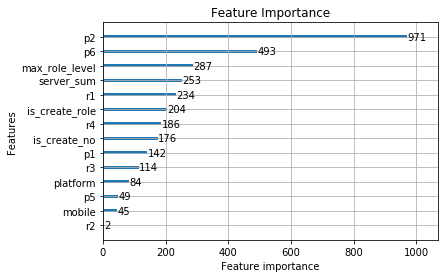

In [89]:
plt.figure(figsize=(20,10))
lgb.plot_importance(lgb_r_cv, max_num_features=15)
plt.title('Feature Importance')
plt.show()

# 使用data_test测试模型

In [46]:
print(data_test.shape)
print(data_test['role_id'].nunique())
data_test.head()

(1291093, 23)
1291093


,role_id,r1,r2,r3,r4,max_role_level,p1,p2,p3,p4,p5,p6,is_create_role,is_create_no,server_sum,platform,user_type,user_flag,mobile,game_pay_num,chmoney_pay_num,30d_pay_money,continue_pay
4039179,146380823,1,1,1,0.00,2,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0
4666004,148858219,1,1,1,0.00,5,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0
709795,150303074,1,1,1,0.00,4,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0
105493,148843558,1,1,1,0.00,0,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0
1941782,150776574,1,1,1,0.00,4,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0


In [47]:
# data_test_features = data_test.drop(['role_id', 'game_pay_num', 'chmoney_pay_num', '30d_pay_money', 'continue_pay'], axis=1)
# target_continue_pay = data_test['continue_pay']
# target_30_pay_money = data_test['30d_pay_money']

## part1

In [48]:
# 把前7天没有付费的角色提出来，直接预测前30天不会付费
data_test_nopay_7 = data_test[data_test['p2'] == 0]
data_test_part1 = data_test_nopay_7[['role_id', 'p2']].rename(columns={'p2':'predict_30_pay'})

In [49]:
print(data_test_part1.shape)
data_test_part1.head()

(1262201, 2)


,role_id,predict_30_pay
4039179,146380823,0.00
4666004,148858219,0.00
709795,150303074,0.00
105493,148843558,0.00
1941782,150776574,0.00


In [50]:
print(len(np.intersect1d(data_test_part1['role_id'], data_test['role_id'])))

1262201


## part2

In [51]:
# 预测前7天付费，但后面不再付费的角色，直接预测前30天付费金额=前7天付费金额
data_test_pay_7 = data_test[data_test['p2'] != 0]

In [52]:
print(data_test_pay_7.shape)
data_test_pay_7.head()

(28892, 23)


,role_id,r1,r2,r3,r4,max_role_level,p1,p2,p3,p4,p5,p6,is_create_role,is_create_no,server_sum,platform,user_type,user_flag,mobile,game_pay_num,chmoney_pay_num,30d_pay_money,continue_pay
3590611,12161074,141,1,19,1.19,1,19.00,1022.00,0.00,0.00,19.00,1022.00,1.00,1.00,1.00,2.00,1.00,1.00,0.00,0.00,0.00,4306.00,1
2543047,142745794,12,1,3,13.73,56,1.00,12.00,0.00,0.00,1.00,12.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,12.00,0
4996918,140927358,48,1,4,3.49,0,6.00,120.00,0.00,0.00,6.00,120.00,0.00,0.00,4.00,1.00,20.00,1.00,0.00,0.00,0.00,120.00,0
1045097,143017890,60,1,17,2.79,65,1.00,12.00,0.00,0.00,1.00,12.00,1.00,1.00,2.00,1.00,1.00,1.00,0.00,0.00,0.00,208.00,1
2578237,140632685,39,1,19,3.73,66,1.00,30.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,30.00,0


In [53]:
features_data_test_pay_7 = data_test_pay_7.drop(['role_id', 'game_pay_num', 'chmoney_pay_num', 
                                                 '30d_pay_money', 'continue_pay'], axis=1)
y_predict = lgb_b_cv.predict(features_data_test_pay_7)

In [54]:
sessoin = pd.DataFrame(y_predict, columns=['continue_pay'])
sessoin['continue_pay']=sessoin['continue_pay'].apply(lambda x:1 if x>=0.4 else 0)
y_predict_val = sessoin['continue_pay'].values
print(recall_score(data_test_pay_7['continue_pay'], y_predict_val, average=None))
print(precision_score(data_test_pay_7['continue_pay'], y_predict_val))
print(accuracy_score(data_test_pay_7['continue_pay'], y_predict_val))
print(f1_score(data_test_pay_7['continue_pay'], y_predict_val))

[0.75368716 0.76129533]
0.6317991631799164
0.7564031565831372
0.690528537507695


In [55]:
data_test_pay_7['predict_continue_pay'] = y_predict_val

C:\Users\Administrator\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [56]:
data_test_pay_7['predict_continue_pay'].value_counts()

0    16464
1    12428
Name: predict_continue_pay, dtype: int64

In [57]:
# 把前7天有付费预测后面不再付费的角色提出来，直接预测前30天=前7天付费
data_test_pay_7_nopay_30 = data_test_pay_7[data_test_pay_7['predict_continue_pay'] == 0]
data_test_part2 = data_test_pay_7_nopay_30[['role_id', 'p2']].rename(columns={'p2':'predict_30_pay'})

In [58]:
print(data_test_part2.shape)
data_test_part2.head()

(16464, 2)


,role_id,predict_30_pay
2543047,142745794,12.00
1045097,143017890,12.00
2578237,140632685,30.00
3945109,136367858,12.00
3862790,133895179,116.00


In [59]:
print(len(np.intersect1d(data_test_part2['role_id'], data_test['role_id'])))

16464


## part3

In [60]:
# 提取前7天付费且预测未来30天继续付费的角色，进行回归预测
data_test_pay_7_pay_30 = data_test_pay_7[data_test_pay_7['predict_continue_pay'] == 1]

In [61]:
data_test_pay_7_pay_30.shape

(12428, 24)

In [62]:
features_data_test_pay_7_pay_30 = data_test_pay_7_pay_30.drop(['role_id', 'game_pay_num', 'chmoney_pay_num', 
                                                 '30d_pay_money', 'continue_pay','predict_continue_pay'], axis=1)
y_predict = lgb_r_cv.predict(features_data_test_pay_7_pay_30)

In [63]:
mse = mean_squared_error(np.expm1(y_predict), data_test_pay_7_pay_30['30d_pay_money'])
mae = mean_absolute_error(np.expm1(y_predict), data_test_pay_7_pay_30['30d_pay_money'])
rmse = mse ** 0.5
print(rmse)
print(mse)
print(mae)

3258.790030838822
10619712.465094492
933.5158879968828


In [64]:
from sklearn.metrics import mean_squared_log_error
rmsle = mean_squared_log_error(np.expm1(y_predict), data_test_pay_7_pay_30['30d_pay_money']) ** 0.5
print(rmsle)

0.7867108818123671


In [65]:
data_test_pay_7_pay_30['predict_30_pay'] = np.expm1(y_predict)
data_test_part3 = data_test_pay_7_pay_30[['role_id', 'predict_30_pay']]

C:\Users\Administrator\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [66]:
print(len(np.intersect1d(data_test_part3['role_id'], data_test['role_id'])))

12428


In [67]:
print(data_test_part1.shape)
print(data_test_part2.shape)
print(data_test_part3.shape)

(1262201, 2)
(16464, 2)
(12428, 2)


In [68]:
np.intersect1d(data_test_part3['role_id'], data_test_part2['role_id'])

array([], dtype=int64)

In [69]:
data_test_part1.head()

,role_id,predict_30_pay
4039179,146380823,0.00
4666004,148858219,0.00
709795,150303074,0.00
105493,148843558,0.00
1941782,150776574,0.00


In [70]:
pred = data_test_part1.append(data_test_part2).append(data_test_part3)
print(pred.shape)

(1291093, 2)


In [71]:
print(len(np.intersect1d(pred['role_id'], data_test['role_id'])))

1291093


In [72]:
pred.head()

,role_id,predict_30_pay
4039179,146380823,0.00
4666004,148858219,0.00
709795,150303074,0.00
105493,148843558,0.00
1941782,150776574,0.00


In [73]:
predict_data = pd.merge(data_test[['role_id', '30d_pay_money']],pred,on='role_id',how='left',validate='one_to_one')
predict_data.sort_values('predict_30_pay', ascending=False).head(50)

,role_id,30d_pay_money,predict_30_pay
469784,12697075,31940.00,37547.19
1076628,11729260,51698.00,37427.19
918182,12066031,53766.00,37427.19
930539,11729064,79822.00,37427.19
1005370,12535797,35206.00,36668.51
1280073,11740437,56666.00,36551.32
415783,12001837,39650.00,36124.57
230340,11872690,60216.00,36095.80
762227,12689262,37754.00,36087.90
822808,13540473,42404.00,35913.80


In [74]:
predict_data[predict_data['predict_30_pay'] >0].sort_values('predict_30_pay').head(50)

,role_id,30d_pay_money,predict_30_pay
972849,152464362,2.00,2.00
985979,136238389,6.00,6.00
208852,141469096,6.00,6.00
1079717,149124504,6.00,6.00
1168689,141177541,6.00,6.00
644650,146309577,48.00,12.00
625564,12103968,158.00,12.00
625798,11767434,12.00,12.00
626152,11324216,12.00,12.00
626235,13542082,12.00,12.00


In [75]:
predict_data.isna().sum()

role_id           0
30d_pay_money     0
predict_30_pay    0
dtype: int64

In [76]:
mse = mean_squared_error(predict_data['predict_30_pay'], predict_data['30d_pay_money'])
mae = mean_absolute_error(predict_data['predict_30_pay'], predict_data['30d_pay_money'])
rmse = mse ** 0.5
print('测试集上的均方根误差:%.2f元'% rmse)
# print('测试集上的均方误差:%f元' % mse)
print('测试集上的平均绝对误差:%.2f元'% mae)

测试集上的均方根误差:326.62元
测试集上的平均绝对误差:9.92元


In [77]:
print('测试集前30天实际总的付费金额:%.2f元' % predict_data['30d_pay_money'].sum())
print('测试集前30天预测总的付费金额:%.2f元'% predict_data['predict_30_pay'].sum())
print('预测总金额准确率:',predict_data['predict_30_pay'].sum()/predict_data['30d_pay_money'].sum())

测试集前30天实际总的付费金额:24365500.00元
测试集前30天预测总的付费金额:20402653.62元
预测总金额准确率: 0.8373582982093087


In [78]:
print((predict_data['30d_pay_money'].sum()-predict_data['predict_30_pay'].sum())/predict_data['30d_pay_money'].sum())

0.1626417017906913


# 大R

In [79]:
data_big_R = predict_data[predict_data['30d_pay_money'] >=2000]
predict_big_R = predict_data[predict_data['predict_30_pay'] >=2000]

In [80]:
print(data_big_R.shape)
print(predict_big_R.shape)
print(len(np.intersect1d(data_big_R['role_id'], predict_big_R['role_id'])))
print('大R预测准确率:%.4f'%(len(np.intersect1d(data_big_R['role_id'], predict_big_R['role_id']))/data_big_R.shape[0]))

(2022, 3)
(1843, 3)
1465
大R预测准确率:0.7245


In [81]:
data_big_R = predict_data[predict_data['30d_pay_money'] >=5000]
predict_big_R = predict_data[predict_data['predict_30_pay'] >=5000]
print(data_big_R.shape)
print(predict_big_R.shape)
print(len(np.intersect1d(data_big_R['role_id'], predict_big_R['role_id'])))
print('大R预测准确率:%.4f'%(len(np.intersect1d(data_big_R['role_id'], predict_big_R['role_id']))/data_big_R.shape[0]))

(973, 3)
(849, 3)
640
大R预测准确率:0.6578


In [82]:
data_big_R = predict_data[predict_data['30d_pay_money'] >=8000]
predict_big_R = predict_data[predict_data['predict_30_pay'] >=8000]
print(data_big_R.shape)
print(predict_big_R.shape)
print(len(np.intersect1d(data_big_R['role_id'], predict_big_R['role_id'])))
print('大R预测准确率:%.4f'%(len(np.intersect1d(data_big_R['role_id'], predict_big_R['role_id']))/data_big_R.shape[0]))

(616, 3)
(467, 3)
364
大R预测准确率:0.5909


In [83]:
data_big_R = predict_data[predict_data['30d_pay_money'] >=10000]
predict_big_R = predict_data[predict_data['predict_30_pay'] >=10000]
print(data_big_R.shape)
print(predict_big_R.shape)
print(len(np.intersect1d(data_big_R['role_id'], predict_big_R['role_id'])))
print('大R预测准确率:%.4f'%(len(np.intersect1d(data_big_R['role_id'], predict_big_R['role_id']))/data_big_R.shape[0]))

(470, 3)
(377, 3)
278
大R预测准确率:0.5915


In [84]:
data_big_R = predict_data[predict_data['30d_pay_money'] >= 15000]
predict_big_R = predict_data[predict_data['predict_30_pay'] >=15000]
print(data_big_R.shape)
print(predict_big_R.shape)
print(len(np.intersect1d(data_big_R['role_id'], predict_big_R['role_id'])))
print('大R预测准确率:%.4f'%(len(np.intersect1d(data_big_R['role_id'], predict_big_R['role_id']))/data_big_R.shape[0]))

(298, 3)
(202, 3)
156
大R预测准确率:0.5235


In [85]:
a = [1, 2, 4, 6]
b = [3, 2, 4, 5]
c = np.intersect1d(a, b)
d = np.setdiff1d(a, b)
e = np.union1d(a, b)

In [86]:
print(c, d, e)

[2 4] [1 6] [1 2 3 4 5 6]


In [87]:
np.in1d(a, b)

array([False,  True,  True, False])

In [88]:
np.setxor1d(a,b)

array([1, 3, 5, 6])

# 玩家流失